# Introduction

This notebook contains the data cleaning and amalgamation for the final plot of the main body of my paper. 
The notebook also explores some other samples that we do not include, and includes brief descriptions of the methodology, limitations and attributes of each study.

# TODO
missing 
- mendez delgado 22
- berg 19
- berg 16

# Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits
import json
import matplotlib as mpl
import os
import toml

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
from surp import ViceModel, yields, subgiants, DATA_DIR
from surp import gce_math as gcem

import surp
import arya
from arya import COLORS

In [4]:
surp.set_yields()

In [5]:
import sys; sys.path.append("..")

In [6]:
from singlezone import run_singlezone, exp_sfh

In [7]:
def to_nice(apogee_name):
    return "[" + apogee_name.title().replace("_", "/") + "]"

In [8]:
def plot_abund_errs(df, x="O_H", y="C_O", fmt="o", **kwargs):
    xs = df[x].values
    ys =  df[y].values
    xerr = df[f"{x}_err"].values
    yerr = df[f"{y}_err"].values
    filt = ~np.isnan(xerr) 
    filt &= ~np.isnan(yerr)
    filt &= xerr > 0
    filt &= yerr > 0
    
    plt.errorbar(xs[filt], ys[filt], xerr=xerr[filt], yerr=yerr[filt], fmt=fmt, capsize=0, **kwargs)
    plt.xlabel(to_nice(x))
    plt.ylabel(to_nice(y))

In [9]:
def plot_sample(df, **kwargs):    
    plot_abund_errs(df, x="FE_H", y="O_FE", **kwargs)
    plt.show()
    
    plot_abund_errs(df, **kwargs)
    plt.show()
    
    plot_abund_errs(df, x="O_FE", **kwargs)
    plt.show()
    
    if "MG_FE" in df.columns:
        plot_abund_errs(df, x="O_H", y="O_MG", **kwargs)
        plot_abund_errs(df, x="MG_H", y="C_MG", **kwargs)
        plot_abund_errs(df, x="MG_FE", y="C_MG", **kwargs)
        plt.show()
                    

In [10]:
def calc_errs(df, idx=None):
    series = pd.Series()
    series["O_H_err"] = np.nanmean(df["O_H_err"])
    series["C_O_err"] = np.nanmean(df["C_O_err"])
    
    if idx is None:
        O_H = np.mean(df.O_H)
        C_O = np.mean(df.C_O)
        
        idx = np.argmin((df.O_H - O_H)**2 )#+ (df.C_O - C_O)**2)
        series["O_H"] = df.O_H.iloc[idx]
        series["C_O"] = df.C_O.iloc[idx]
    
    return series.to_frame().T

In [11]:
def plot_sample_err(df, df_err, color=COLORS[0], marker="*", label="", **kwargs):
    plt.scatter(df["O_H"], df["C_O"], marker=marker, color=color, label=label, **kwargs)
    

    plt.errorbar(df_err["O_H"], df_err["C_O"],  xerr=df_err.O_H_err, yerr=df_err.C_O_err,
             marker="none", ls="none", color=color, capsize=0, **kwargs)
    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [12]:
c_o_correction = np.log10(12.01/15.99) - np.log10(vice.solar_z("c") / vice.solar_z("o"))
eps_o_correction =  - 12 + np.log10(15.99) - np.log10(vice.solar_z("o"))

In [13]:
import toml

In [14]:
def contains_min_cols(d, cols):
    for col in cols:
        if col not in d.keys():
            print("missing", col)
            return False
    return True

In [15]:
def toml_to_df(y):
    df = pd.DataFrame()

    for row in y:
        row_df = pd.DataFrame(row)
        df = pd.concat([df, row_df], ignore_index=True)
        
    return df

In [16]:
def parsetoml(filename):
    df = {}
    with open(filename, "r") as f:
        df = toml.load(f)
    return df

In [17]:
def format_with_errors(value, error, precision):
    """
    Format a value and its error with LaTeX formatting and rounding precision.

    Parameters:
    - value (float): The value to format.
    - error (float): The corresponding error.
    - precision (int): The number of decimal places to round to.

    Returns:
    - str: A string formatted with LaTeX math mode including $\pm$.
    """
    return f"${value:.{precision}f} \pm {error:.{precision}f}$"

In [18]:
def dataframe_to_latex_with_errors(df, precisions, caption='', label='', index=False):
    """
    Convert a pandas DataFrame to a LaTeX table, handling columns with errors.

    Parameters:
    - df (pd.DataFrame): The DataFrame to convert.
    - precisions (dict): A dictionary specifying the rounding precision for each column.
    - caption (str): Caption for the table.
    - label (str): Label for referencing the table in LaTeX.
    - index (bool): Whether to include the DataFrame's index in the table.

    Returns:
    - str: A LaTeX tabular environment as a string.
    """
    # Create a copy of the DataFrame to modify
    df_copy = df.copy()

    # Iterate over the columns and format those with companion `_err` columns
    for col in df.columns:
        if col.endswith('_err'):
            main_col = col[:-4]  # Get the corresponding main column name
            if main_col in df.columns:
                precision = precisions.get(main_col, 2)  # Default precision to 2 if not specified
                df_copy[main_col] = df.apply(lambda row: format_with_errors(row[main_col], row[col], precision), axis=1)
                df_copy.drop(columns=[col], inplace=True)  # Drop the `_err` column after formatting

    # Convert the DataFrame to LaTeX
    latex_table = df_copy.to_latex(index=index, escape=False)

    table_env = f"\\begin{{table}}[H]\n\\centering\n{latex_table}"
    
    if caption:
        table_env += f"\\caption{{{caption}}}\n"
    if label:
        table_env += f"\\label{{{label}}}\n"
    
    table_env += "\\end{table}"
    
    return table_env

# Stars
Samples of MW stars.
See also `catalogues` and `clean_surveys` notebooks.

## Amarsi et al. (2019)
3D NLTE corrected sample

Builds on: 
- Nissen et al. (2014)
- Amarsi et al. (2019a) which therein builds on  Nissen et al. (2007). which contains most of what Fabbian et al. (2009) presents.

In [19]:
amarsi19 = pd.read_csv(surp.DATA_DIR + "stellar_catalogues/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)

amarsi19["FE_H"] = amarsi19["[Fe/H]3L"]
amarsi19["FE_H_err"] = amarsi19["e_[Fe/H]3L"]

amarsi19["O_H"] = amarsi19["[O/H]3N"]
amarsi19["O_H_err"] = amarsi19["e_[O/H]3N"]

amarsi19["C_H"] = amarsi19["[C/H]3N"]
amarsi19["C_H_err"] = amarsi19["e_[C/H]3N"]

amarsi19["C_O"] = amarsi19["C_H"] - amarsi19["O_H"] 
amarsi19["C_O_err"] = amarsi19["O_H_err"] + amarsi19["C_H_err"] 

amarsi19["O_FE"] = amarsi19["O_H"] - amarsi19["[Fe/H]3L"]
amarsi19["O_FE_err"] = amarsi19["e_[Fe/H]3L"] + amarsi19["O_H_err"]

amarsi19_sun = amarsi19.iloc[151]
amarsi19.drop(index=151, inplace=True)

/tmp/ipykernel_2647991/45189048.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  amarsi19 = pd.read_csv(surp.DATA_DIR + "stellar_catalogues/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)


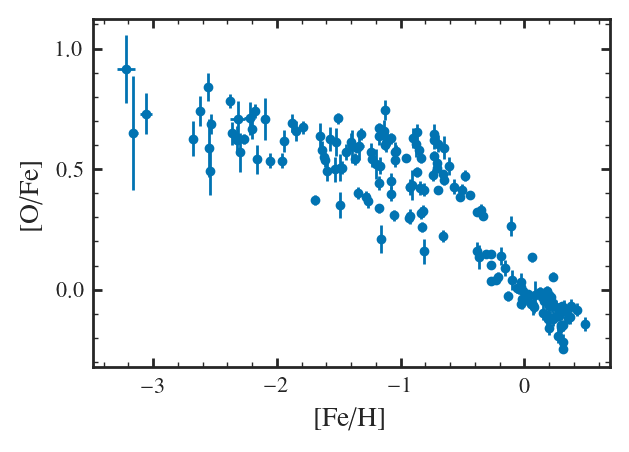

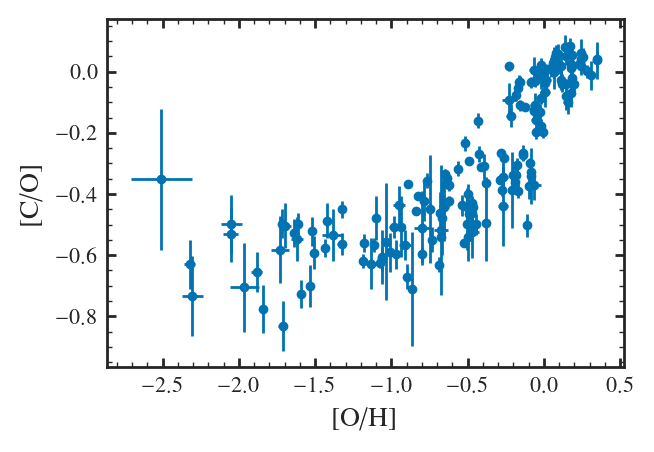

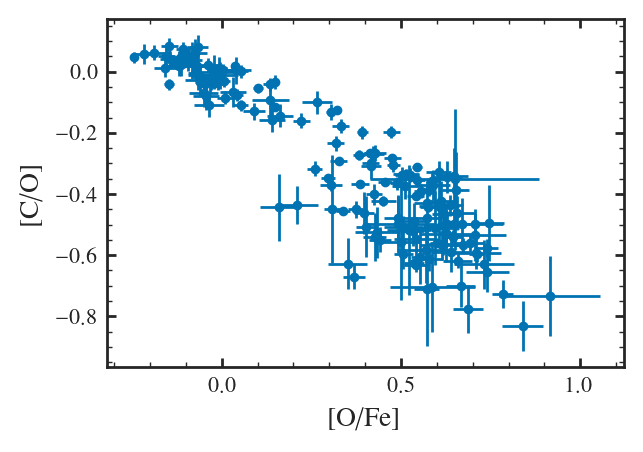

In [20]:
plot_sample(amarsi19)

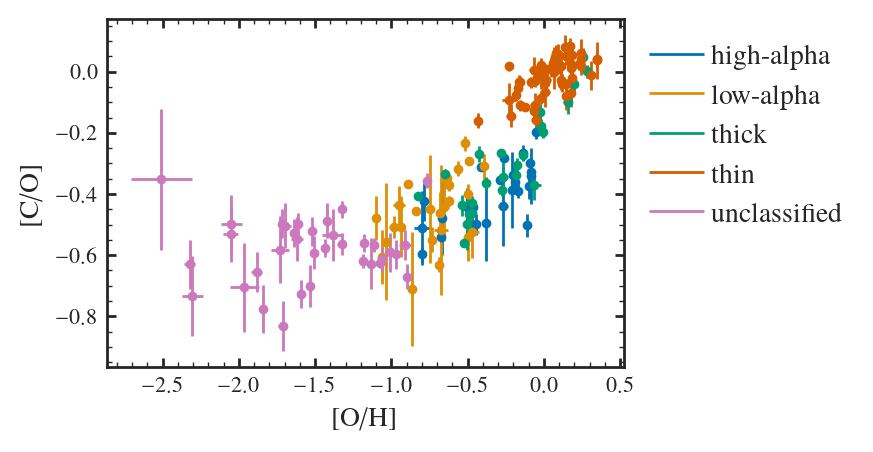

In [21]:
for pop in amarsi19.Pop.unique():
    filt = amarsi19.Pop == pop
    plot_abund_errs(amarsi19[filt], label=pop)

arya.Legend(-1)


Text(0, 0.5, 'C_O')

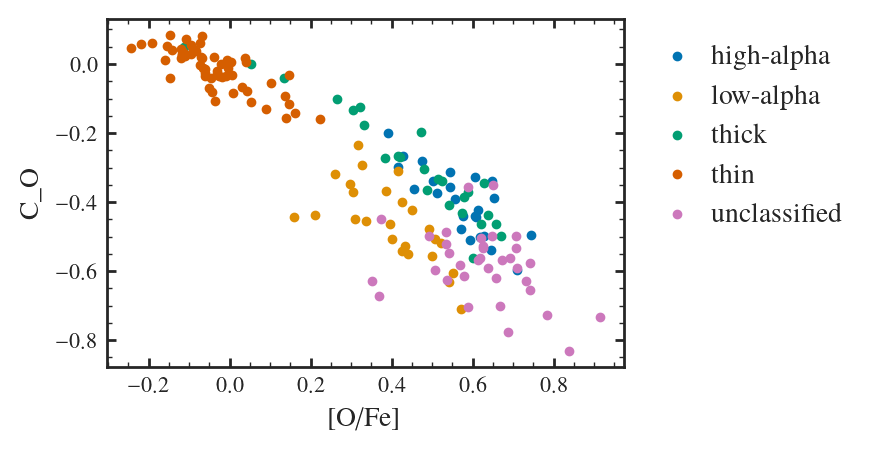

In [22]:
for pop in amarsi19.Pop.unique():
    filt = amarsi19.Pop == pop
    plt.scatter(amarsi19[filt].O_FE, amarsi19[filt]["C_O"], label=pop)

arya.Legend(-1)
plt.xlabel("[O/Fe]")
plt.ylabel("C_O")

### NLTE vs LTE

while e.g. Fe is stable, C requires up to -0.2 dex corrections at low metallicities.

Text(0, 0.5, '3D LTE - 1D LTE')

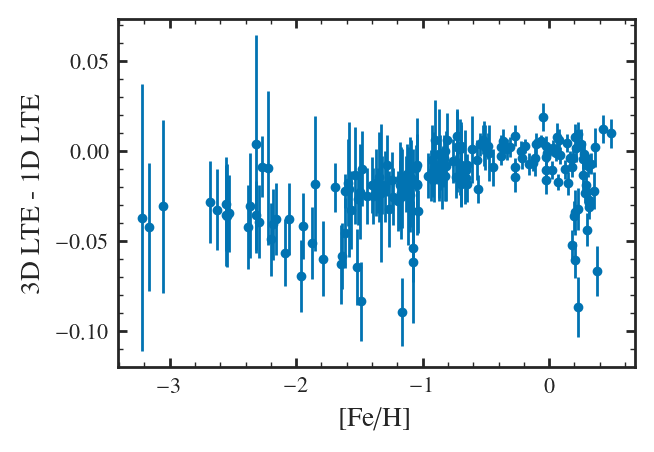

In [23]:
plt.errorbar(amarsi19.FE_H, amarsi19["[Fe/H]1L"] - amarsi19["[Fe/H]3L"], yerr=amarsi19["e_[Fe/H]3L"], fmt="o", capsize=0)
plt.xlabel("[Fe/H]")
plt.ylabel("3D LTE - 1D LTE")

Text(0, 0.5, '1D LTE - 3D NLTE')

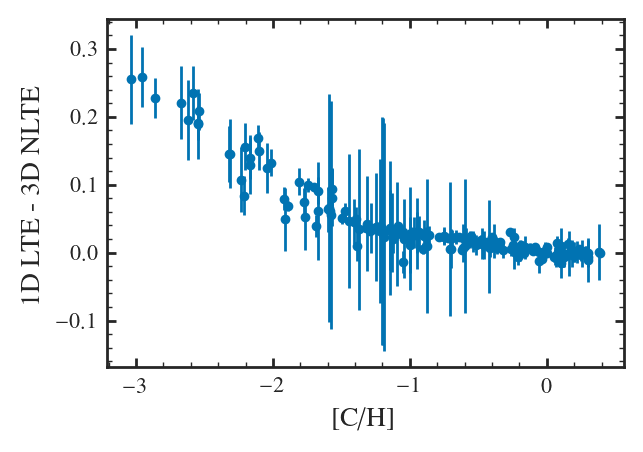

In [24]:
plt.errorbar(amarsi19.C_H, amarsi19["[C/H]1L"] - amarsi19["[C/H]3N"], yerr=amarsi19["e_[C/H]3N"], fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("1D LTE - 3D NLTE")

Text(0, 0.5, '1D LTE - 3D NLTE')

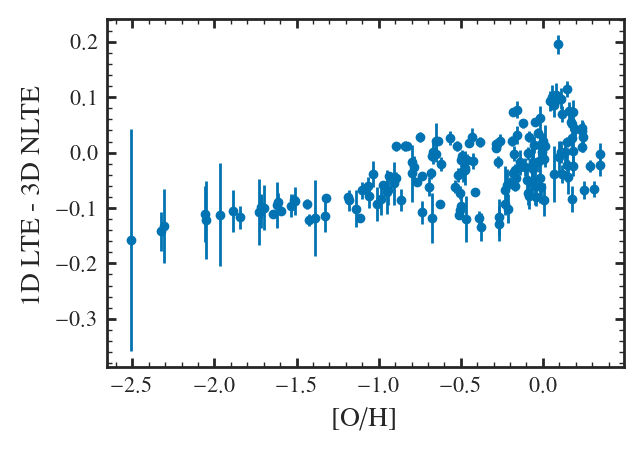

In [25]:
plt.errorbar(amarsi19.O_H, amarsi19["[O/H]1L"] - amarsi19["[O/H]3N"], yerr=amarsi19["e_[O/H]3N"], fmt="o", capsize=0)
plt.xlabel("[O/H]")
plt.ylabel("1D LTE - 3D NLTE")

In [26]:
amarsi19.to_csv("amarsi19_cleaned.csv")

## Zhao et al. 2016
https://ui.adsabs.harvard.edu/abs/2016ApJ...833..225Z/abstract


NLTE 1D abundances. MW thin, thick, and halo stars.
- 51 nearby stars -
- lick on 3m with R~60k from 3700-9300Å, S/N > 100 for most.
- about 10 C lines, most are around 9000Å.
- NonLTE - LTE for C is ~0 at 5052Å, but are  ~ -0.1dex  at 9111Å. not correlated with Fe.
- Also includes CH and C2 bands


In [27]:
z16_long = pd.read_csv(DATA_DIR + "stellar_catalogues/zhao+2016.tsv", delimiter="\t[ ]*", comment="#")

/tmp/ipykernel_2647991/1670974911.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  z16_long = pd.read_csv(DATA_DIR + "stellar_catalogues/zhao+2016.tsv", delimiter="\t[ ]*", comment="#")


In [28]:
z16_long

,Name,Teff,logg,[Fe/H],xi,Pop,Z,Species,N,[X/H]LTE,e_[X/H]LTE,[X/Fe]LTE,[X/H]NLTE,e_[X/H]NLTE,[X/Fe]NLTE
0,HD 19373,6045,4.24,0.10,1.2,Thin disk,3.0,Li I,1,2.50,NaN,NaN,2.47,NaN,NaN
1,HD 19373,6045,4.24,0.10,1.2,Thin disk,6.0,C I,5,0.00,0.04,-0.10,-0.05,0.05,-0.15
2,HD 19373,6045,4.24,0.10,1.2,Thin disk,NaN,CH,13,0.10,0.06,0.00,NaN,NaN,NaN
3,HD 19373,6045,4.24,0.10,1.2,Thin disk,8.0,O I,4,0.01,0.01,-0.09,-0.06,0.04,-0.16
4,HD 19373,6045,4.24,0.10,1.2,Thin disk,11.0,Na I,4,0.27,0.06,0.17,0.21,0.04,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,G090-003,6007,3.90,-2.04,1.3,Halo,29.0,Cu I,0,NaN,NaN,NaN,NaN,NaN,NaN
1016,G090-003,6007,3.90,-2.04,1.3,Halo,38.0,Sr II,2,-1.98,0.01,0.06,-2.13,0.00,-0.09
1017,G090-003,6007,3.90,-2.04,1.3,Halo,40.0,Zr II,2,-1.67,0.05,0.37,-1.65,0.04,0.39
1018,G090-003,6007,3.90,-2.04,1.3,Halo,56.0,Ba II,4,-2.12,0.07,-0.08,-2.00,0.05,0.04


In [29]:
z16 = z16_long.pivot_table(index='Name', columns='Species', 
    values=['[X/H]LTE', 'e_[X/H]LTE', '[X/Fe]LTE', '[X/H]NLTE', 'e_[X/H]NLTE','[X/Fe]NLTE'], aggfunc='first')


In [30]:
z16.columns = [a.replace("X", b.strip()).replace("NLTE", "") for a, b in z16.columns.values]

In [31]:
z16 = pd.merge(z16_long[["Name", "Teff", "logg", "[Fe/H]", "xi"]].drop_duplicates(), z16, on='Name')

In [32]:
z16.columns.values

array(['Name', 'Teff', 'logg', '[Fe/H]', 'xi', '[Al I/Fe]LTE',
       '[Ba II/Fe]LTE', '[C I/Fe]LTE', '[CH/Fe]LTE', '[Ca I/Fe]LTE',
       '[Cu I/Fe]LTE', '[Eu II/Fe]LTE', '[Fe I/Fe]LTE', '[Fe II/Fe]LTE',
       '[K I/Fe]LTE', '[Mg I/Fe]LTE', '[Na I/Fe]LTE', '[O I/Fe]LTE',
       '[Sc II/Fe]LTE', '[Si I/Fe]LTE', '[Si II/Fe]LTE', '[Sr II/Fe]LTE',
       '[Ti II/Fe]LTE', '[Zr II/Fe]LTE', '[Al I/Fe]', '[Ba II/Fe]',
       '[C I/Fe]', '[Ca I/Fe]', '[Cu I/Fe]', '[Eu II/Fe]', '[Fe I/Fe]',
       '[Fe II/Fe]', '[K I/Fe]', '[Mg I/Fe]', '[Na I/Fe]', '[O I/Fe]',
       '[Sc II/Fe]', '[Si I/Fe]', '[Si II/Fe]', '[Sr II/Fe]',
       '[Ti II/Fe]', '[Zr II/Fe]', '[Al I/H]LTE', '[Ba II/H]LTE',
       '[C I/H]LTE', '[CH/H]LTE', '[Ca I/H]LTE', '[Cu I/H]LTE',
       '[Eu II/H]LTE', '[Fe I/H]LTE', '[Fe II/H]LTE', '[K I/H]LTE',
       '[Li I/H]LTE', '[Mg I/H]LTE', '[Na I/H]LTE', '[O I/H]LTE',
       '[Sc II/H]LTE', '[Si I/H]LTE', '[Si II/H]LTE', '[Sr II/H]LTE',
       '[Ti II/H]LTE', '[Zr II/H]LTE', '[Al I

Text(0, 0.5, 'logg')

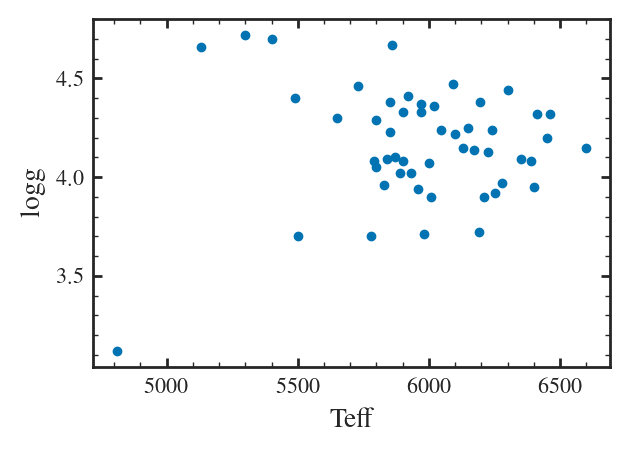

In [33]:
plt.scatter(z16.Teff, z16.logg)
plt.xlabel("Teff")
plt.ylabel("logg")

In [34]:
z16["C_H"] = z16["[C I/H]"] 
z16["C_H_err"] = z16["e_[C I/H]"] 


z16["C_O"] = z16["[C I/H]"] - z16["[O I/H]"]
z16["C_O_err"] = z16["e_[C I/H]"] - z16["e_[O I/H]"]

z16["O_H"] = z16["[O I/H]"]
z16["O_H_err"] = z16["e_[O I/H]"]

z16["FE_H"] = z16["[Fe I/H]"]
z16["FE_H_err"] = z16["e_[Fe I/H]"]

z16["O_FE"] = z16["[O I/Fe]"]
z16["O_FE_err"] = z16["e_[O I/H]"] + z16["e_[Fe I/H]"]

Text(0, 0.5, '1D LTE - 3D NLTE')

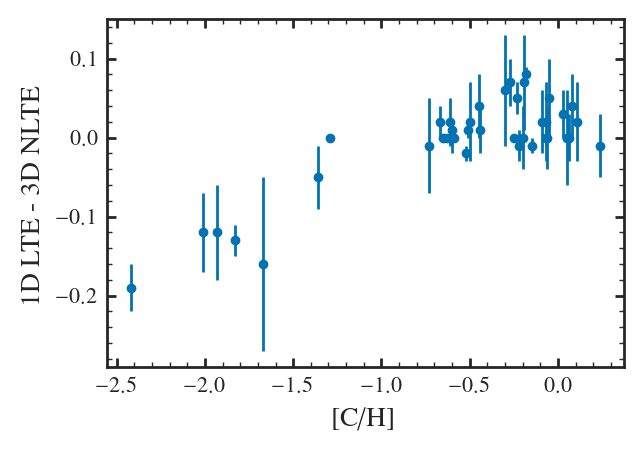

In [35]:
plt.errorbar(z16.C_H, z16["[C I/H]LTE"] - z16.C_H, yerr=z16.C_H_err, fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("1D LTE - 3D NLTE")

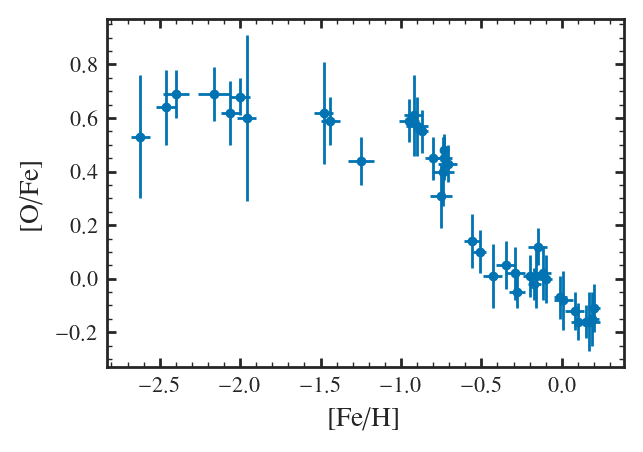

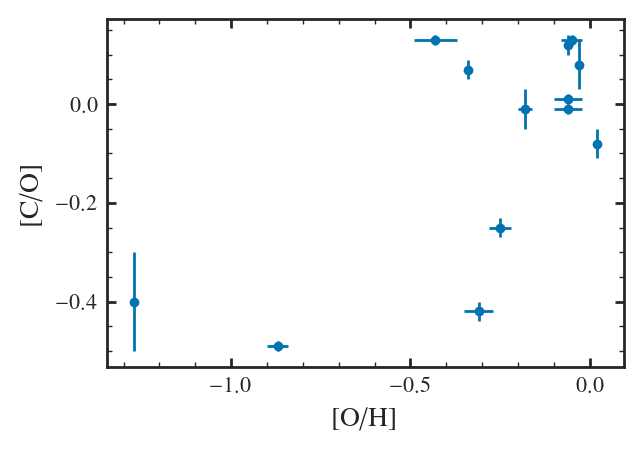

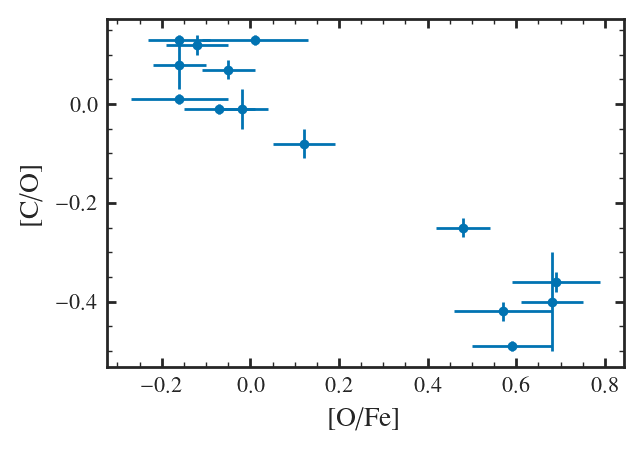

In [36]:
plot_sample(z16)

Text(0, 0.5, ' LTE - NLTE')

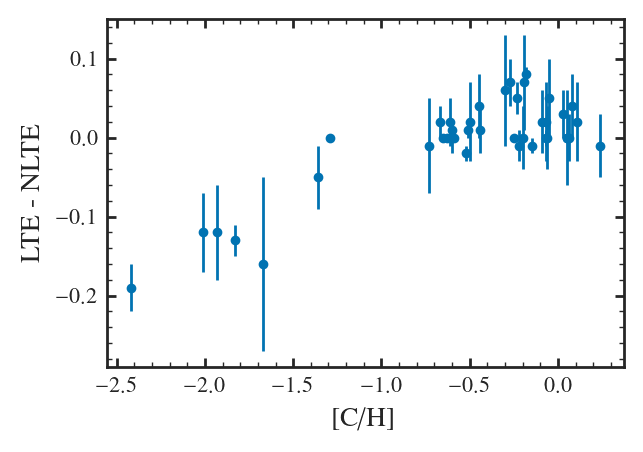

In [37]:
plt.errorbar(z16.C_H, z16["[C I/H]LTE"] - z16.C_H, yerr=z16.C_H_err, fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel(" LTE - NLTE")

Text(0, 0.5, 'CH - C I')

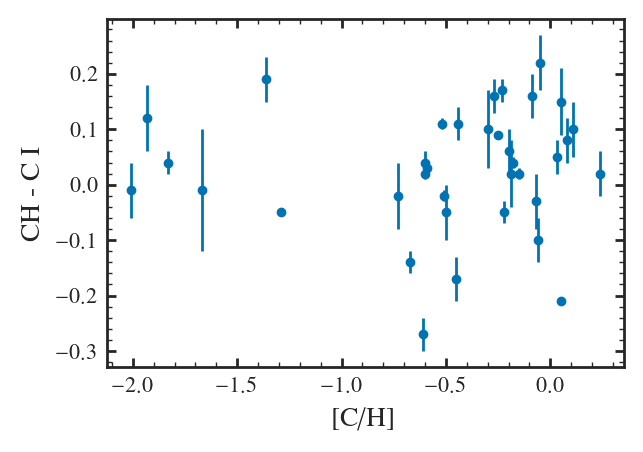

In [38]:
plt.errorbar(z16.C_H, z16["[CH/Fe]LTE"] - z16.C_H + z16.FE_H, yerr=z16.C_H_err, fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("CH - C I")

Text(0, 0.5, '1D LTE - 3D NLTE')

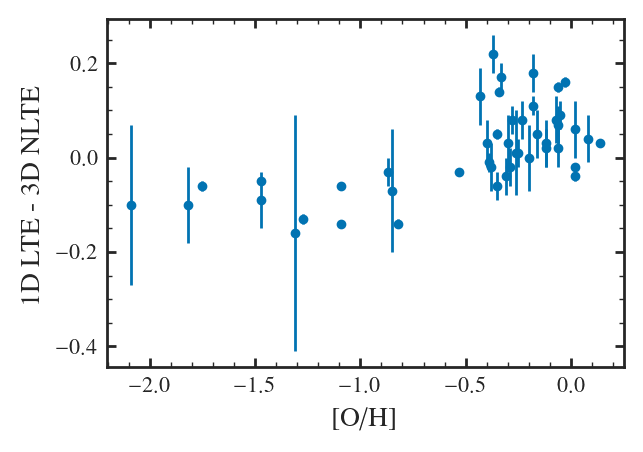

In [39]:
plt.errorbar(z16.O_H, z16["[O I/H]LTE"] - z16.O_H, yerr=z16.O_H_err, fmt="o", capsize=0)
plt.xlabel("[O/H]")
plt.ylabel("1D LTE - 3D NLTE")

In [40]:
z16.to_csv("zhao+16_cleaned.csv")

## Combined

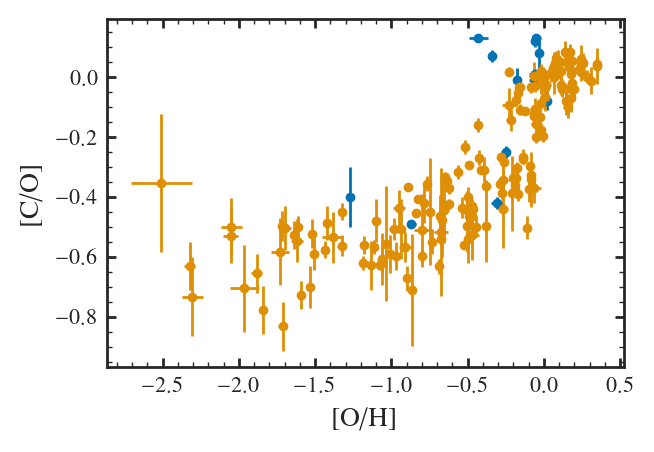

In [41]:
plot_abund_errs(z16)
plot_abund_errs(amarsi19)

## Extra

### bedell 18
solar twins sample. https://ui.adsabs.harvard.edu/abs/2018ApJ...865...68B/abstract.
Doesn't help with global trends since all stars almost same


In [41]:
b18 = pd.read_csv(DATA_DIR + "stellar_catalogues/bedell18.dat", delimiter=" +", comment="#")

/tmp/ipykernel_2276503/1288262885.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  b18 = pd.read_csv(DATA_DIR + "stellar_catalogues/bedell18.dat", delimiter=" +", comment="#")


Text(0, 0.5, '[C/O]')

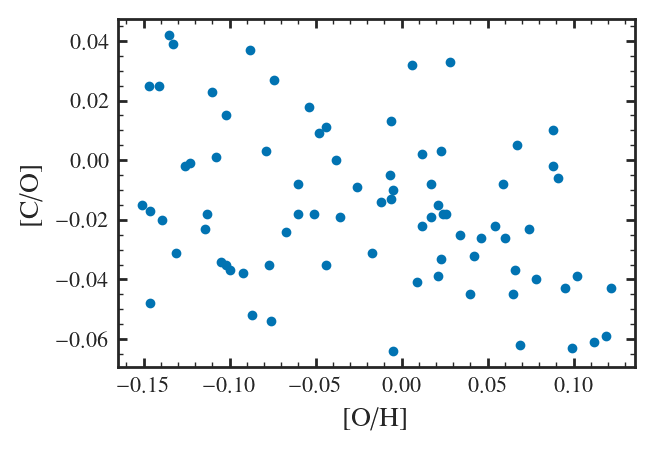

In [42]:
plt.scatter(b18["[OI/H]"], b18["[CI/H]"] - b18["[OI/H]"])
plt.xlabel("[O/H]")
plt.ylabel("[C/O]")

### Bensby et al. (2019, 2021)
The galactic bulge sample

In [43]:
bensby21 = pd.read_csv(DATA_DIR + "stellar_catalogues/bensby21.tsv", delimiter="\t *", comment="#",engine='python')
bensby19 = pd.read_csv(DATA_DIR + "stellar_catalogues/bensby19.tsv", delimiter="\t *", comment="#",engine='python')

bensby = bensby21.set_index("Name").join(bensby19.set_index("Name"),rsuffix="_b19", how="left")

bensby["C_O"] = bensby["[C/H]"] - bensby["[O/H]"]
bensby["C_O_err"] = bensby["e_[C/O]"]

bensby["O_FE"] = bensby["[O/H]"] - bensby["[Fe/H]"]
bensby["O_FE_err"] = bensby["e_[O/H]"] + bensby["e_[Fe/H]"]

bensby["O_H"] = bensby["[O/H]"]
bensby["O_H_err"] = bensby["e_[O/H]"]

bensby["FE_H"] = bensby["[Fe/H]"]
bensby["FE_H_err"] = bensby["e_[Fe/H]"]


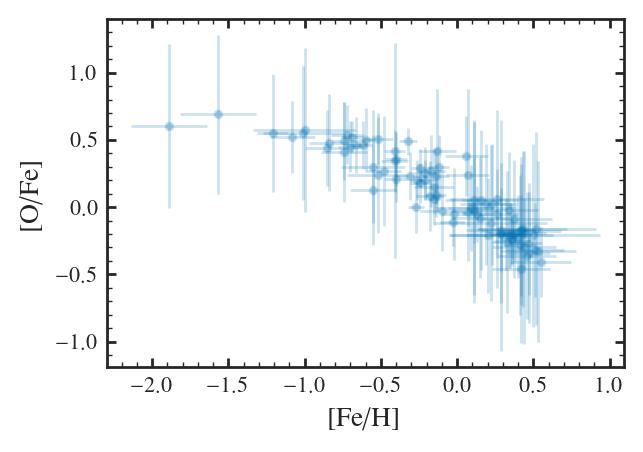

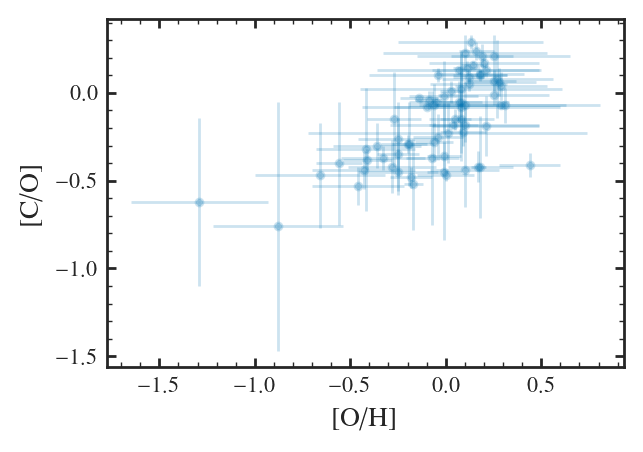

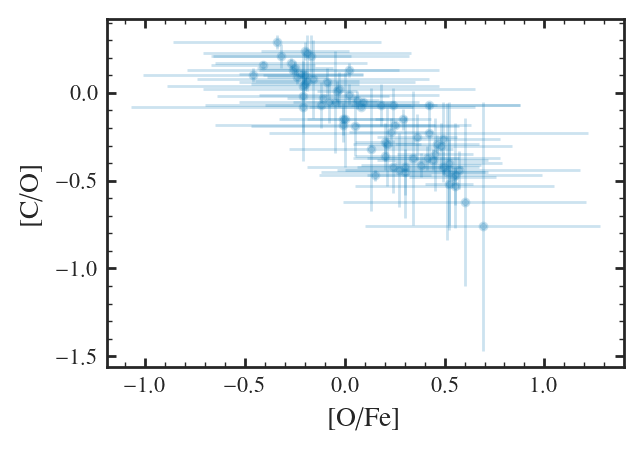

In [44]:
plot_sample(bensby, alpha=0.2)

### Fabbian et al. 2009
Rehashed in Amarsi

In [45]:
F09 = pd.read_csv(DATA_DIR + "stellar_catalogues/Fabbian09.csv", sep="\s+")

# RL

work from
- Esteban et al . (2002, 2009, 2014)
- García-Rojas et al. (2007)
- López-Sánchez et al. (2007)
- Mendez-Delgado et al. 2022
- Skillman et al. (2020)
- Toribio San Cipriano et al. 2016, 2017.
- Peimbert et al. 2005


Other
- Peimberg 2003 does 30 Dor in LMC (like TSC)
- García-Rojas 2003, 2004, 2006 (galactic regions)
- Tsamis et al. 2003. (galactic and LMC, covered by more modern studies)



## Esteban + 09

In [42]:
E09 = pd.read_csv(DATA_DIR +  "nearby_RL/esteban+09.tsv", comment="#", sep=r"\t")
E09["O_H"] = gcem.eps_to_brak(E09.eps_o, "O")
E09["O_H_err"] = E09.o_err
E09["C_H"] = gcem.eps_to_brak(E09.eps_c, "C")
E09["C_H_err"] =E09.c_err
E09["C_O"] = E09.C_H - E09.O_H
E09["C_O_err"] = E09.C_H_err + E09.O_H_err
E09["study"] = "esteban+09"
E09

/tmp/ipykernel_2647991/4268016898.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  E09 = pd.read_csv(DATA_DIR +  "nearby_RL/esteban+09.tsv", comment="#", sep=r"\t")


,galaxy,class,region,eps_c,c_err,eps_n,n_err,eps_o,o_err,eps_fe,fe_err,O_H,O_H_err,C_H,C_H_err,C_O,C_O_err,study
0,M31,spiral,K932,8.46,0.13,7.63,0.06,8.62,0.03,5.90,0.09,-0.193789,0.03,-0.143419,0.13,0.05037,0.16,esteban+09
1,M33,spiral,NGC 595,8.53,0.12,7.53,0.10,8.69,0.05,5.55,0.21,-0.123789,0.05,-0.073419,0.12,0.05037,0.17,esteban+09
2,M33,spiral,NGC 604,8.40,0.11,7.49,0.07,8.60,0.03,5.94,0.11,-0.213789,0.03,-0.203419,0.11,0.01037,0.14,esteban+09
3,NGC 2366,magellanic,NGC-2363,7.75,0.09,6.70,0.10,8.04,0.05,5.71,0.23,-0.773789,0.05,-0.853419,0.09,-0.07963,0.14,esteban+09
4,NGC 2403,spiral,VS 24,8.46,0.24,7.35,0.07,8.37,0.04,5.71,0.19,-0.443789,0.04,-0.143419,0.24,0.30037,0.28,esteban+09
5,NGC 2403,spiral,VS 38,8.50,0.15,7.23,0.11,8.29,0.05,5.58,0.35,-0.523789,0.05,-0.103419,0.15,0.42037,0.20,esteban+09
6,NGC 2403,spiral,VS 44,8.32,0.18,7.52,0.08,8.61,0.04,6.13,0.12,-0.203789,0.04,-0.283419,0.18,-0.07963,0.22,esteban+09
7,M101,spiral,H1013,8.67,0.12,7.82,0.19,8.73,0.09,5.98,0.26,-0.083789,0.09,0.066581,0.12,0.15037,0.21,esteban+09
8,M101,spiral,NGC 5461,8.30,0.20,7.54,0.11,8.49,0.06,6.15,0.21,-0.323789,0.06,-0.303419,0.20,0.02037,0.26,esteban+09
9,M101,spiral,NGC 5447,8.20,0.12,7.39,0.13,8.52,0.06,6.23,0.35,-0.293789,0.06,-0.403419,0.12,-0.10963,0.18,esteban+09


In [43]:
E09.sort_values("eps_o")

,galaxy,class,region,eps_c,c_err,eps_n,n_err,eps_o,o_err,eps_fe,fe_err,O_H,O_H_err,C_H,C_H_err,C_O,C_O_err,study
3,NGC 2366,magellanic,NGC-2363,7.75,0.09,6.70,0.10,8.04,0.05,5.71,0.23,-0.773789,0.05,-0.853419,0.09,-0.07963,0.14,esteban+09
12,NGC 4861,BCD,Brightest,NaN,NaN,6.56,0.28,8.05,0.04,5.45,0.33,-0.763789,0.04,NaN,NaN,NaN,NaN,esteban+09
11,NGC 4395,SA(s)m,Reg 70,NaN,NaN,6.56,0.28,8.09,0.15,5.97,0.42,-0.723789,0.15,NaN,NaN,NaN,NaN,esteban+09
5,NGC 2403,spiral,VS 38,8.50,0.15,7.23,0.11,8.29,0.05,5.58,0.35,-0.523789,0.05,-0.103419,0.15,0.42037,0.20,esteban+09
4,NGC 2403,spiral,VS 24,8.46,0.24,7.35,0.07,8.37,0.04,5.71,0.19,-0.443789,0.04,-0.143419,0.24,0.30037,0.28,esteban+09
10,NGC 1741,Im-D,Zone C,NaN,NaN,7.36,0.18,8.41,0.06,5.95,0.25,-0.403789,0.06,NaN,NaN,NaN,NaN,esteban+09
8,M101,spiral,NGC 5461,8.30,0.20,7.54,0.11,8.49,0.06,6.15,0.21,-0.323789,0.06,-0.303419,0.20,0.02037,0.26,esteban+09
9,M101,spiral,NGC 5447,8.20,0.12,7.39,0.13,8.52,0.06,6.23,0.35,-0.293789,0.06,-0.403419,0.12,-0.10963,0.18,esteban+09
2,M33,spiral,NGC 604,8.40,0.11,7.49,0.07,8.60,0.03,5.94,0.11,-0.213789,0.03,-0.203419,0.11,0.01037,0.14,esteban+09
6,NGC 2403,spiral,VS 44,8.32,0.18,7.52,0.08,8.61,0.04,6.13,0.12,-0.203789,0.04,-0.283419,0.18,-0.07963,0.22,esteban+09


VS-24 and VS-38 have large abundance discrepancies from Garnett measurements, so I believe this is why they are excluded?

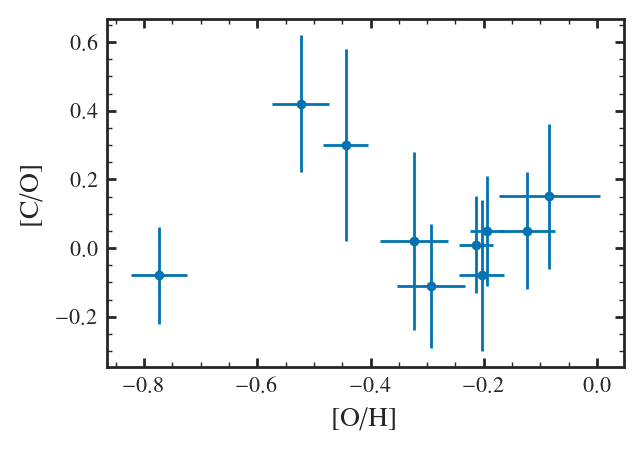

In [44]:
plot_abund_errs(E09.loc[~np.isin(E09.region, ["VS-24", "VS-38"])])

Reproduced except for NGC 5447 which I believe they take the average of t^2 > 0 and t^2 = 0 values for oxygen whereas I just use t^2 > 0.

## Esteban + 2014

In [45]:
E14 = pd.read_csv(DATA_DIR +  "nearby_RL/esteban+14.tsv", comment="#", sep=r"\t")
E14["O_H"] = gcem.eps_to_brak(E14.eps_o, "O")
E14["O_H_err"] = E14.o_err
E14["C_H"] = gcem.eps_to_brak(E14.eps_c, "C")
E14["C_H_err"] =E14.c_err
E14["C_O"] = E14.C_H - E14.O_H
E14["C_O_err"] = E14.C_H_err + E14.O_H_err
E14["study"] = "esteban+14"
E14

/tmp/ipykernel_2647991/3499897804.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  E14 = pd.read_csv(DATA_DIR +  "nearby_RL/esteban+14.tsv", comment="#", sep=r"\t")


,galaxy,class,region,eps_c,c_err,eps_n,n_err,eps_o,o_err,eps_fe,fe_err,O_H,O_H_err,C_H,C_H_err,C_O,C_O_err,study
0,NGC 6822,dwarf,centre,7.83,0.10,6.94,0.09,8.35,0.05,6.05,0.17,-0.463789,0.05,-0.773419,0.10,-0.30963,0.15,esteban+14
1,NGC 5408,dwarf,centre,7.59,0.15,6.72,0.08,8.21,0.04,6.03,0.10,-0.603789,0.04,-1.013419,0.15,-0.40963,0.19,esteban+14
2,Tol 1924-416,?,centre,NaN,NaN,6.59,0.06,7.99,0.02,6.05,0.10,-0.823789,0.02,NaN,NaN,NaN,NaN,esteban+14
3,NGC 3125,?,centre,8.18,NaN,7.48,0.12,8.69,0.08,6.94,0.22,-0.123789,0.08,-0.423419,NaN,-0.29963,NaN,esteban+14
4,Mrk 1271,?,centre,8.27,NaN,7.17,0.30,8.71,0.13,6.22,0.36,-0.103789,0.13,-0.333419,NaN,-0.22963,NaN,esteban+14
5,POX 4,?,centre,8.11,NaN,6.63,0.07,8.30,NaN,5.98,0.13,-0.513789,NaN,-0.493419,NaN,0.02037,NaN,esteban+14
6,SDSS J1253-0312,?,centre,7.70,NaN,7.14,0.08,7.99,0.02,6.28,0.11,-0.823789,0.02,-0.903419,NaN,-0.07963,NaN,esteban+14
7,Tol 1457-0312,?,centre,NaN,NaN,6.78,0.06,8.21,0.02,6.28,0.12,-0.603789,0.02,NaN,NaN,NaN,NaN,esteban+14
8,He 2-10,?,centre,NaN,NaN,7.67,0.14,8.55,0.02,6.34,0.16,-0.263789,0.02,NaN,NaN,NaN,NaN,esteban+14


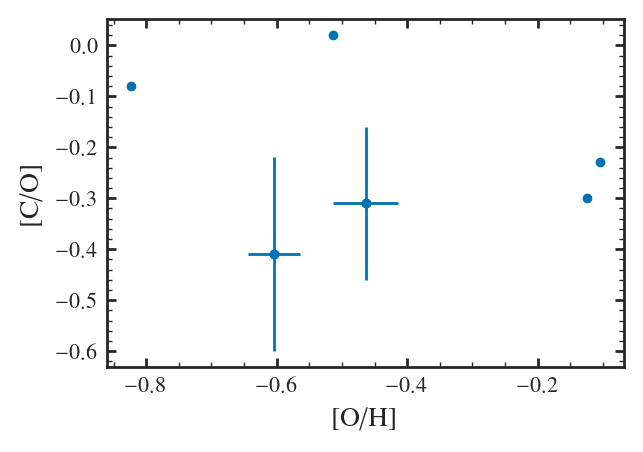

In [46]:
plot_abund_errs(E14)
plt.scatter(E14.O_H, E14.C_O)

Verified. Note that only the ones with errors match. I believe they also take the average of t^2=0 and t^2>0 values, but all of these detections are very weak and the oxygen abundance is low, so it is reasonable to exclude these objects.

## Mendez-Delgado et al. 2022
MW HII regions

In [231]:
def read_md22():
    df = pd.read_csv(DATA_DIR +  "nearby_RL/mendez-delgado+22.tsv", comment="#", sep="\t+")
    df1 =df
    df1["O_H"] = gcem.eps_to_brak(df["eps_o"], "o")
    df1["C_H"] = gcem.eps_to_brak(df["eps_c"], "c")
    df1["C_O"] = df1["C_H"] - df1["O_H"]

    df1["O_H_err"] = df["eps_o_err"]
    df1["C_O_err"] = df["eps_c_err"] + df["eps_o_err"]

    df1.name = "Milkyway"
    return df1
    
md22 = read_md22()

/tmp/ipykernel_2647991/103446840.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(DATA_DIR +  "nearby_RL/mendez-delgado+22.tsv", comment="#", sep="\t+")


In [232]:
md22

,region,eps_c,eps_c_err,eps_o,eps_o_err,R_g,R_g_err,O_H,C_H,C_O,O_H_err,C_O_err
0,Sh 2-311,8.26,0.09,8.58,0.05,11.60,0.44,-0.233789,-0.343419,-0.10963,0.05,0.14
1,NGC 2579,8.20,0.06,8.61,0.06,10.82,0.44,-0.203789,-0.403419,-0.19963,0.06,0.12
2,NGC 3576,8.50,0.04,8.79,0.04,7.66,0.10,-0.023789,-0.103419,-0.07963,0.04,0.08
3,NGC 3603,8.54,0.07,8.70,0.05,8.61,0.11,-0.113789,-0.063419,0.05037,0.05,0.12
4,M8,8.53,0.06,8.69,0.05,6.99,0.14,-0.123789,-0.073419,0.05037,0.05,0.11
5,M16,8.62,0.10,8.79,0.06,6.58,0.27,-0.023789,0.016581,0.04037,0.06,0.16
6,M17,8.80,0.04,8.83,0.05,6.46,0.25,0.016211,0.196581,0.18037,0.05,0.09
7,M20,8.52,0.19,8.76,0.05,6.79,0.18,-0.053789,-0.083419,-0.02963,0.05,0.24
8,M42,8.47,0.05,8.78,0.05,8.54,0.11,-0.033789,-0.133419,-0.09963,0.05,0.10


Text(0, 0.5, 'eps C')

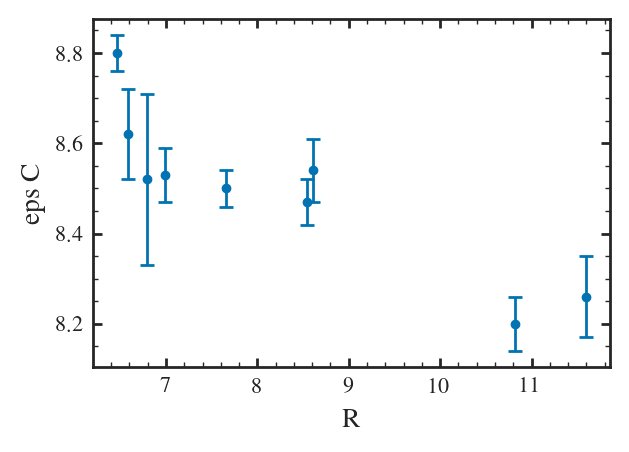

In [233]:
plt.errorbar(md22.R_g, md22.eps_c, yerr=md22.eps_c_err, fmt="o")
plt.xlabel("R")
plt.ylabel("eps C")

Text(0, 0.5, 'eps O')

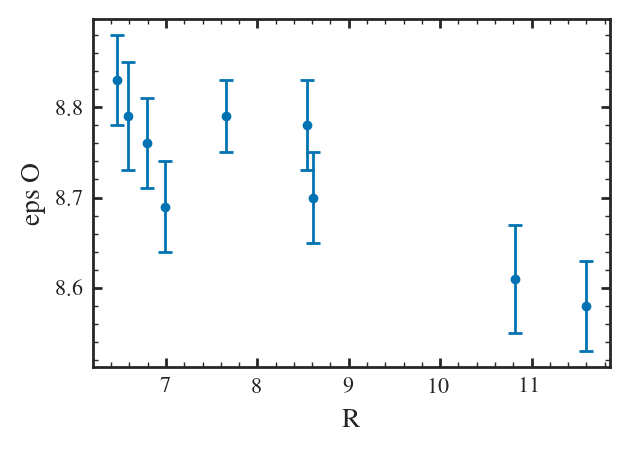

In [234]:
plt.errorbar(md22.R_g, md22.eps_o, yerr=md22.eps_o_err, fmt="o")
plt.xlabel("R")
plt.ylabel("eps O")

Not Verified :///

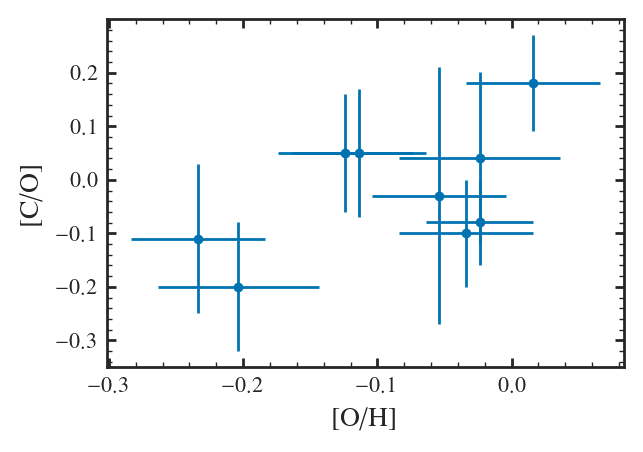

In [235]:
plot_abund_errs(md22)

## Skillman et al. 2020
M101 data from CHAOS
Recombination lines

LBT
CII λ4267 with ionization corrections

In [70]:
def read_skillman20():
    df = pd.read_csv(DATA_DIR + "nearby_RL/skillman+20.tsv", sep="\t")
    df1 = pd.DataFrame()
    df1["O_H"] = gcem.eps_to_brak(df["O_H"], "o")
    df1["C_O"] = gcem.log_to_brak(df["C_O"], "c", "o")
    df1["[c/n]"] = gcem.log_to_brak(df["C_N"], "c", "n")
    df1["[n/o]"] = df1["C_O"] - df1["[c/n]"]

    df1["O_H_err"] = df["O_H_err"]
    df1["C_O_err"] = df["C_O_err"] 
    df1["[c/n]_err"] = df["C_N_err"] * 12/14
    df1["[n/o]_err"] = df["C_O_err"] + df["C_N_err"]

    df1["galaxy"] ="M101"
    df1["region"] = df.region
    df1["study"] = "skillman+20"
    return df1

skillman20 = read_skillman20()

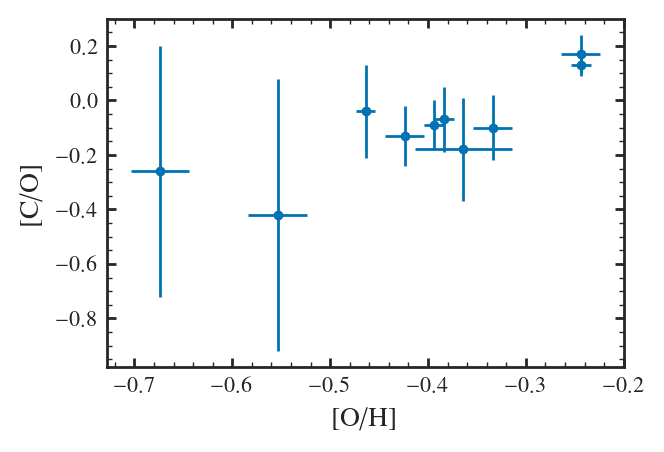

In [71]:
plot_abund_errs(skillman20)

Verified

##  Toribio San Cipriano et al. (2016)
NGC 300 and M33 abundances using RL on UVES

In [72]:
tsc16 = pd.read_csv(f"{DATA_DIR}/nearby_RL/TSC16.tsv", sep="\t", comment="#")

In [73]:
tsc16.columns

Index(['galaxy', 'region', 'eps_o', 'eps_o_err', 'log_c_o', 'log_c_o_err'], dtype='object')

In [74]:
tsc16["O_H"] = gcem.eps_to_brak(tsc16.eps_o, "o")
tsc16["O_H_err"] = tsc16.eps_o_err
tsc16["C_O"] = gcem.log_to_brak(tsc16.log_c_o, "c", "o")
tsc16["C_O_err"] = tsc16.log_c_o_err
tsc16["study"] = "toribo-san-cipriano+16"

In [75]:
tsc16

,galaxy,region,eps_o,eps_o_err,log_c_o,log_c_o_err,O_H,O_H_err,C_O,C_O_err,study
0,NGC 300,R20,8.69,0.11,-0.22,0.22,-0.123789,0.11,-0.00963,0.22,toribo-san-cipriano+16
1,NGC 300,R23,8.70,0.13,-0.43,0.23,-0.113789,0.13,-0.21963,0.23,toribo-san-cipriano+16
2,NGC 300,R14,8.62,0.11,-0.36,0.21,-0.193789,0.11,-0.14963,0.21,toribo-san-cipriano+16
3,NGC 300,R2,8.57,0.12,-0.52,0.22,-0.243789,0.12,-0.30963,0.22,toribo-san-cipriano+16
4,M33,NGC 588,8.49,0.09,-0.47,0.19,-0.323789,0.09,-0.25963,0.19,toribo-san-cipriano+16
5,M33,IC 132,8.47,0.12,-0.33,0.15,-0.343789,0.12,-0.11963,0.15,toribo-san-cipriano+16


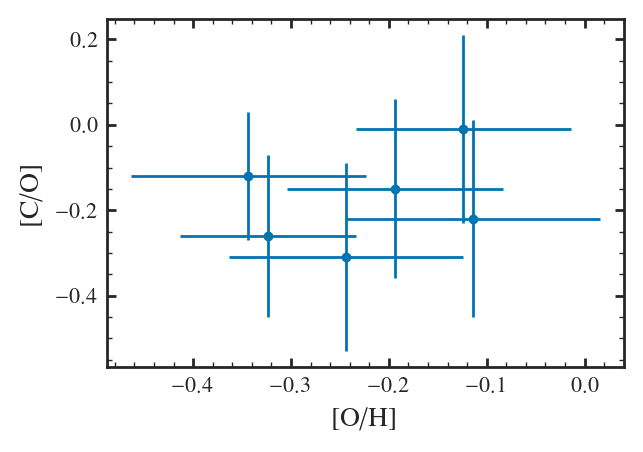

In [76]:
plot_abund_errs(tsc16)

Verified!

##  Toribio San Cipriano et al. (2017)
LMC and SMC abundances using RL, 5 and 4 HII regions respectively.
Compares to CEL lines
- C II 4267.15
- ~ 7 \[O II\] lines

In [77]:
tsc17 = pd.read_csv(f"{DATA_DIR}/nearby_RL/TSC17.tsv", sep="\t", comment="#")

In [78]:
tsc17["O_H"] = gcem.eps_to_brak(tsc17.eps_o, "o")
tsc17["O_H_err"] = tsc17.eps_o_err
tsc17["C_O"] = gcem.log_to_brak(tsc17.log_c_o, "c", "o")
tsc17["C_O_err"] = tsc17.log_c_o_err

tsc17["C_O_2"] = gcem.log_to_brak(tsc17.log_c_o_cel, "c", "o")
tsc17["C_O_2_err"] = tsc17.log_c_o_err
tsc17["study"] = "toribo-san-cipriano+17"

In [79]:
tsc17

,galaxy,region,eps_o,eps_o_err,eps_o_cel,eps_o_cel_err,log_c_o,log_c_o_err,log_c_o_cel,log_c_o_cel_err,O_H,O_H_err,C_O,C_O_err,C_O_2,C_O_2_err,study
0,LMC,30 Dor,8.53,0.04,8.39,0.01,-0.50,0.06,-0.58,0.04,-0.283789,0.04,-0.28963,0.06,-0.36963,0.06,toribo-san-cipriano+17
1,LMC,N44C,8.58,0.02,8.31,0.03,-0.43,0.03,NaN,NaN,-0.233789,0.02,-0.21963,0.03,NaN,0.03,toribo-san-cipriano+17
2,LMC,IC 2111,8.61,0.07,8.43,0.04,-0.42,0.08,-0.43,0.04,-0.203789,0.07,-0.20963,0.08,-0.21963,0.08,toribo-san-cipriano+17
3,LMC,NGC 1714,8.56,0.07,8.37,0.04,-0.45,0.07,-0.47,0.04,-0.253789,0.07,-0.23963,0.07,-0.25963,0.07,toribo-san-cipriano+17
4,LMC,N11B,8.59,0.02,8.39,0.03,-0.48,0.04,NaN,NaN,-0.223789,0.02,-0.26963,0.04,NaN,0.04,toribo-san-cipriano+17
5,SMC,N66A,8.35,0.03,8.00,0.02,-0.67,0.06,-0.86,0.02,-0.463789,0.03,-0.45963,0.06,-0.64963,0.06,toribo-san-cipriano+17
6,SMC,N81,8.34,0.02,8.01,0.02,-0.67,0.04,-0.91,0.02,-0.473789,0.02,-0.45963,0.04,-0.69963,0.04,toribo-san-cipriano+17
7,SMC,NGC 456,8.36,0.09,8.06,0.05,-0.62,0.19,NaN,NaN,-0.453789,0.09,-0.40963,0.19,NaN,0.19,toribo-san-cipriano+17
8,SMC,N88A,8.22,0.02,7.94,0.03,-0.54,0.03,-0.72,0.17,-0.593789,0.02,-0.32963,0.03,-0.50963,0.03,toribo-san-cipriano+17


In [80]:
gcem.log_to_brak(-0.5, "c", "o")

np.float64(-0.28962978981925624)

In [81]:
gcem.log_to_abundance(-3.2, "o")


np.float64(0.007100925493925491)

In [82]:
gcem.eps_to_brak(8.2, "o")

np.float64(-0.6137890187797055)

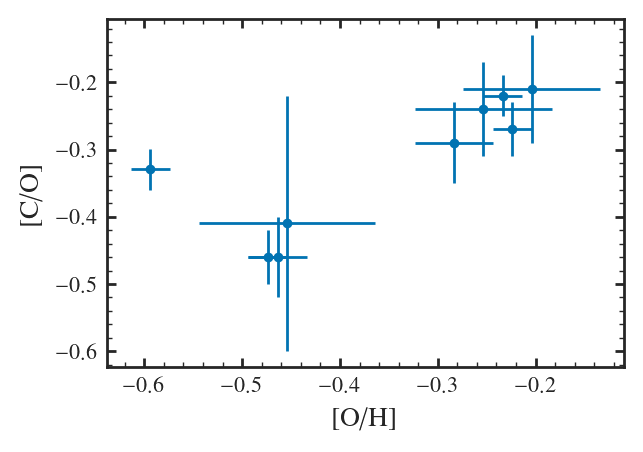

In [83]:
plot_abund_errs(tsc17)

Verified!

Text(0, 0.5, 'change in [C/O] from RL-CEL')

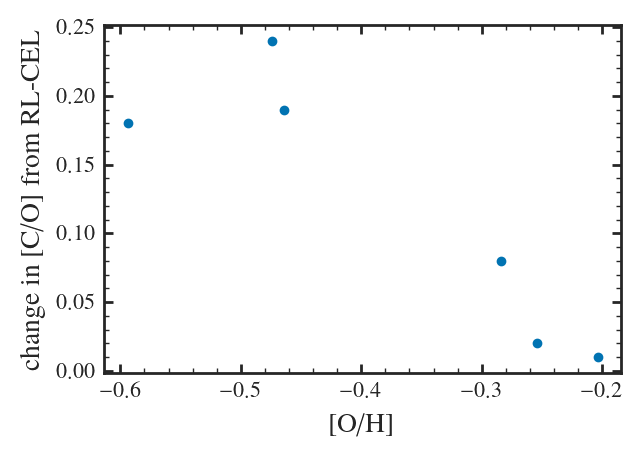

In [84]:
plt.scatter(tsc17.O_H, tsc17.C_O - tsc17.C_O_2)
plt.xlabel("[O/H]")
plt.ylabel("change in [C/O] from RL-CEL")

## Misc

In [85]:
rl_raw = {}

dirname = "../../data/nearby_RL/"
for filename in os.listdir(dirname):
    if filename.startswith("_"):
        continue
    if filename.endswith(".toml"):
        print(filename)
        with open(dirname + filename, "r") as f:
            name = os.path.splitext(filename)[0]
            rl_raw[name] = toml.load(f)


peimbert03.toml
esteban+02.toml
peimbert+05.toml


In [86]:
rl_raw

{'peimbert03': {'link': 'https://ui.adsabs.harvard.edu/abs/2003ApJ...584..735P',
  'notes': 'Abundances for 30-Doradus in the LMC.\nVLT UVES observations of RL lines.\nCalculate ICF and multiple temperature regions.\n',
  'regions': [{'galaxy': 'LMC',
    'class': 'magellanic',
    'region': '30 Dor',
    'eps_C': 8.05,
    'eps_C_err': 0.05,
    'eps_N': 7.21,
    'eps_N_err': 0.08,
    'eps_O': 8.54,
    'eps_O_err': 0.06,
    'eps_Fe': 6.39,
    'eps_Fe_err': 0.2}]},
 'esteban+02': {'notes': 'RL for extragalactic H II regions\nISIS spectrograph on Herschel telescope\n\nNo He II => O IV is minimal so oxygen abundance is just OII + OIII.\nC is derived from CII 4267 recombination line + ICs near unity from garnett ++.\nValues without uncertanties are very low signal to noise. All C derived values assume t^2 value > 0. \nContains also N, S, Ar abundances.\n',
  'citation': 'Esteban C, Peimbert M, Torres-Peimbert S, Rodríguez M. 2002. ApJ. 581(1):241–57',
  'regions': [{'galaxy': 'M33',


In [87]:
cols = ["galaxy", "redshift", "log_HI", "log_HI_err", "log_CII", "log_CII_err", "log_OI", "log_OI_err"]

rl = pd.DataFrame()


for study, attrs in rl_raw.items():
    print(study)
    series = pd.DataFrame(attrs["regions"])
    series["study"] = study
    rl = pd.concat([rl, series], ignore_index=True, axis=0)


peimbert03
esteban+02
peimbert+05


In [88]:
rl

,galaxy,class,region,eps_C,eps_C_err,eps_N,eps_N_err,eps_O,eps_O_err,eps_Fe,eps_Fe_err,study
0,LMC,magellanic,30 Dor,8.05,0.05,7.21,0.08,8.54,0.06,6.39,0.20,peimbert03
1,M33,spiral,NGC 604,8.44,0.06,NaN,NaN,8.66,0.10,6.43,0.09,esteban+02
2,M101,spiral,NGC 5461,8.40,0.10,NaN,NaN,8.81,0.12,6.75,0.08,esteban+02
3,M101,spiral,NGC 5471,7.79,NaN,6.70,0.15,8.23,NaN,6.36,0.09,esteban+02
4,NGC 2366,magellanic,NGC 2363,7.62,NaN,6.70,0.12,8.20,0.11,6.16,0.08,esteban+02
5,NGC 6822,dwarf,region V,8.01,0.12,6.85,0.15,8.37,0.09,NaN,NaN,peimbert+05


In [89]:
rl["C_O"] = gcem.log_to_brak(rl.eps_C - rl.eps_O, "c", "o")
rl["C_O_err"] = rl.eps_C_err + rl.eps_O_err
rl["O_H"] = gcem.eps_to_brak(rl.eps_O, "o")
rl["O_H_err"] = rl.eps_O_err

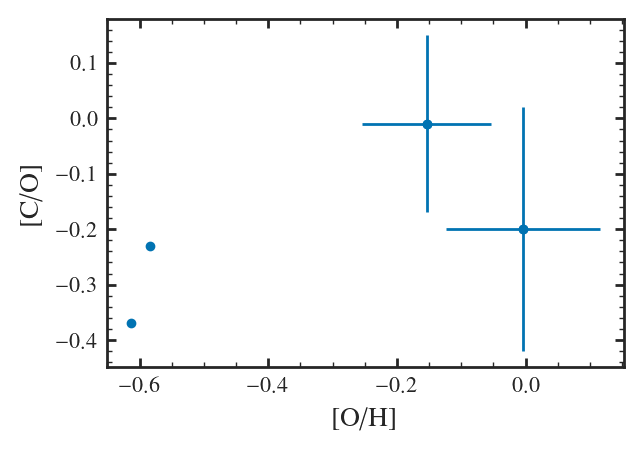

In [90]:
df = rl.loc[rl.study == "esteban+02"]
plt.scatter(df.O_H, df.C_O)
plot_abund_errs(df)


verified

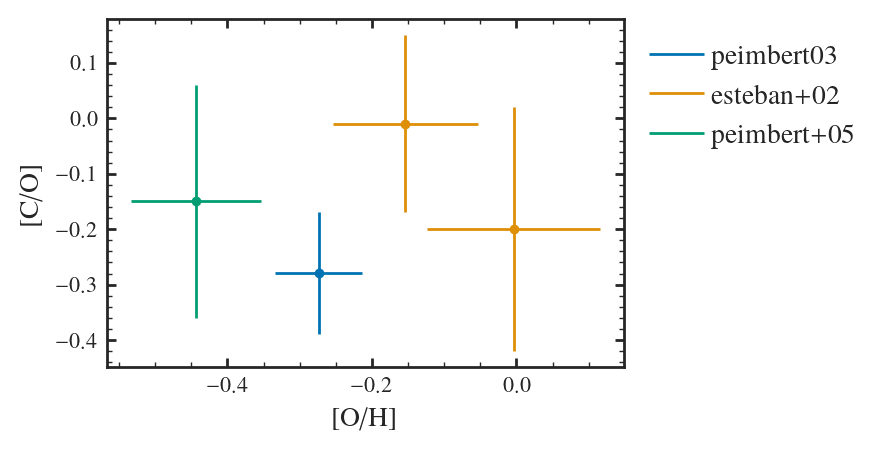

In [91]:
for label in rl.study.unique():
    df = rl.loc[rl.study == label]

    plot_abund_errs(df, label=label)
    
arya.Legend(loc=-1)

## All

In [126]:
tsc17["class"] = "magellanic"
tsc16["class"] = "spiral"

md22["class"] = "MW"
md22["galaxy"] = "MW"
md22["study"] = "mendez-delgado+22"
skillman20["class"] = "spiral"

In [127]:
RLs = pd.concat([rl, md22, skillman20, tsc16, tsc17, E14, E09])
RL_err = calc_errs(RLs)

In [128]:
skillman20

,O_H,C_O,[c/n],[n/o],O_H_err,C_O_err,[c/n]_err,[n/o]_err,galaxy,region,study,class
0,-0.243789,0.17037,0.340067,-0.169697,0.02,0.07,0.068571,0.15,M101,H1013,skillman+20,spiral
1,-0.243789,0.13037,0.350067,-0.219697,0.01,0.04,0.042857,0.09,M101,H1052,skillman+20,spiral
2,-0.333789,-0.09963,0.110067,-0.209697,0.02,0.12,0.111429,0.25,M101,NGC 5461,skillman+20,spiral
3,-0.363789,-0.17963,0.230067,-0.409697,0.05,0.19,0.180000,0.40,M101,NGC 5462,skillman+20,spiral
4,-0.383789,-0.06963,0.320067,-0.389697,0.01,0.12,0.111429,0.25,M101,NGC 5462,skillman+20,spiral
5,-0.423789,-0.12963,0.230067,-0.359697,0.02,0.11,0.111429,0.24,M101,NGC 5455,skillman+20,spiral
6,-0.393789,-0.08963,0.250067,-0.339697,0.01,0.09,0.085714,0.19,M101,NGC 5447,skillman+20,spiral
7,-0.463789,-0.03963,0.300067,-0.339697,0.01,0.17,0.154286,0.35,M101,NGC 5447,skillman+20,spiral
8,-0.553789,-0.41963,0.120067,-0.539697,0.03,0.50,0.428571,1.00,M101,H1216,skillman+20,spiral
9,-0.673789,-0.25963,0.320067,-0.579697,0.03,0.46,0.428571,0.96,M101,NGC 5471,skillman+20,spiral


In [129]:
RL_clean = RLs[~np.isnan(RLs.C_O_err)]

('LMC', '30 Dor')
0                peimbert03
0    toribo-san-cipriano+17
Name: study, dtype: object
('M101', 'H1013')
0    skillman+20
7     esteban+09
Name: study, dtype: object
('M101', 'NGC 5447')
6    skillman+20
7    skillman+20
9     esteban+09
Name: study, dtype: object
('M101', 'NGC 5461')
2     esteban+02
2    skillman+20
8     esteban+09
Name: study, dtype: object
('M101', 'NGC 5462')
3    skillman+20
4    skillman+20
Name: study, dtype: object
('M33', 'NGC 604')
1    esteban+02
2    esteban+09
Name: study, dtype: object


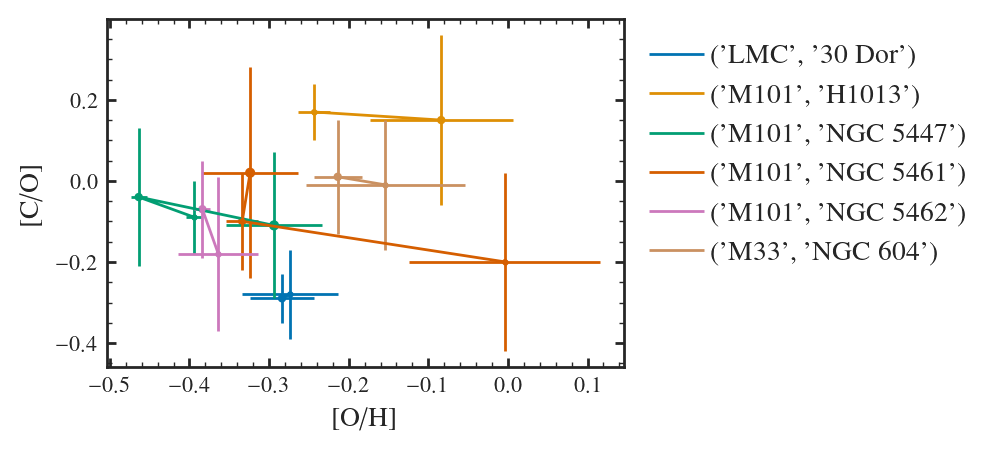

In [130]:
for index, group in RL_clean.groupby(["galaxy", "region"]):
    if len(group) > 1:
        plot_abund_errs(group, label=index, fmt=".-")
        plt.scatter(group.O_H, group.C_O, s=1+ 3*np.arange(len(group)))
        print(index)
        print(group.study)

arya.Legend(-1)

In [131]:
RL_clean[RL_clean[["galaxy", "region"]].duplicated(keep=False)][["galaxy", "region", "study"]].sort_values(["galaxy", "region"])

,galaxy,region,study
0,LMC,30 Dor,peimbert03
0,LMC,30 Dor,toribo-san-cipriano+17
0,M101,H1013,skillman+20
7,M101,H1013,esteban+09
6,M101,NGC 5447,skillman+20
7,M101,NGC 5447,skillman+20
9,M101,NGC 5447,esteban+09
2,M101,NGC 5461,esteban+02
2,M101,NGC 5461,skillman+20
8,M101,NGC 5461,esteban+09


In [132]:
duplicated_filter = ~((RL_clean.galaxy == "LMC") & (RL_clean.region == "30 Dor") & (RL_clean.study != "toribo-san-cipriano+17"))

duplicated_filter &= ~((RL_clean.galaxy == "M101")  & (RL_clean.study != "skillman+20"))
duplicated_filter &= ~((RL_clean.galaxy == "M33") & (RL_clean.region == "NGC 604") & (RL_clean.study != "esteban+09"))


In [133]:
np.sum(~duplicated_filter)

np.int64(6)

In [134]:
RL_clean = RL_clean[duplicated_filter]

In [135]:
RL_clean[RL_clean[["galaxy", "region"]].duplicated(keep=False)][["galaxy", "region", "study"]].sort_values(["galaxy", "region"])

,galaxy,region,study
6,M101,NGC 5447,skillman+20
7,M101,NGC 5447,skillman+20
3,M101,NGC 5462,skillman+20
4,M101,NGC 5462,skillman+20


NGC 6822
dwarf NGC 6822 0.21
MW
M101
NGC 300
M33
LMC
SMC
NGC 5408
dwarf NGC 5408 0.19
M31
NGC 2366
NGC 2403


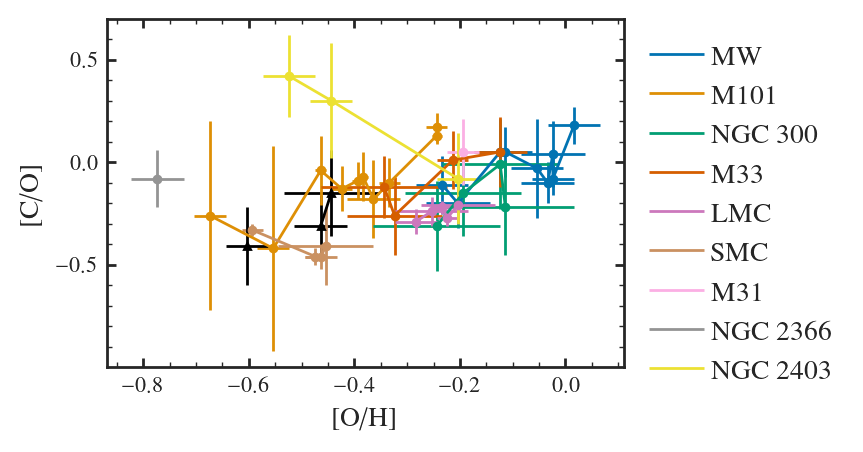

In [136]:
for galaxy in RL_clean.galaxy.unique():
    df = RL_clean.loc[RL_clean.galaxy == galaxy].sort_values("O_H")
    print(galaxy)
    if ((df["class"].iloc[0]) in ["magellanic", "spiral", "MW"]):
        fmt = "o-"
        label=galaxy
    else:
        fmt = "k^-"
        label=""
        print(df["class"].iloc[0], df["galaxy"].iloc[0], df["C_O_err"].iloc[-1])
    plot_abund_errs(df, fmt=fmt, label=label)
arya.Legend(-1)

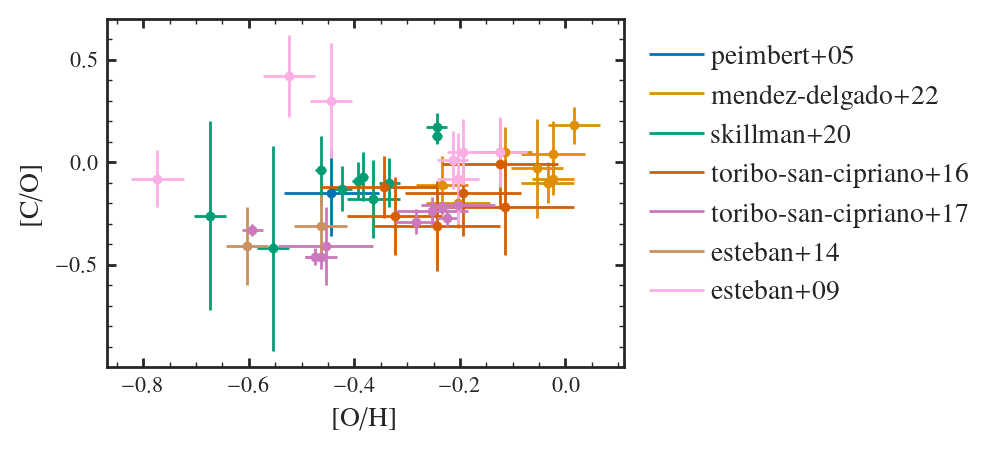

In [137]:
for study in RL_clean.study.unique():
    df = RL_clean.loc[RL_clean.study == study]

  
    plot_abund_errs(df,label=study)
arya.Legend(-1)

## All

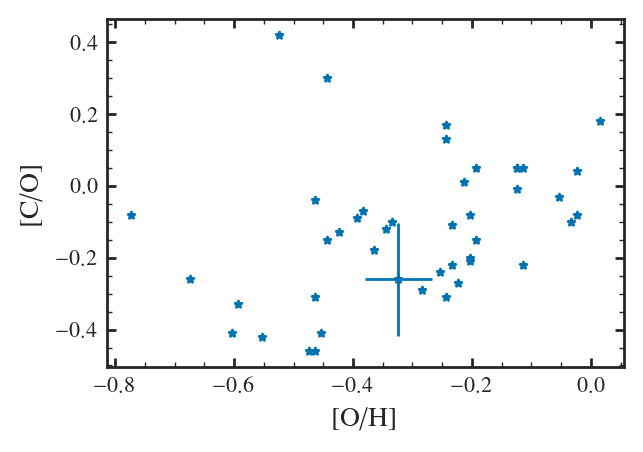

In [138]:
plot_sample_err(RL_clean, RL_err)

In [139]:
RL_clean.to_csv("RL_combined.csv")

In [142]:
RL_clean[["galaxy", "region", "C_O_err", "C_O", "O_H", "O_H_err", "study"]]

,galaxy,region,C_O_err,C_O,O_H,O_H_err,study
5,NGC 6822,region V,0.21,-0.14963,-0.443789,0.09,peimbert+05
0,MW,Sh 2-311,0.14,-0.10963,-0.233789,0.05,mendez-delgado+22
1,MW,NGC 2579,0.12,-0.19963,-0.203789,0.06,mendez-delgado+22
2,MW,NGC 3576,0.08,-0.07963,-0.023789,0.04,mendez-delgado+22
3,MW,NGC 3603,0.12,0.05037,-0.113789,0.05,mendez-delgado+22
4,MW,M8,0.11,0.05037,-0.123789,0.05,mendez-delgado+22
5,MW,M16,0.16,0.04037,-0.023789,0.06,mendez-delgado+22
6,MW,M17,0.09,0.18037,0.016211,0.05,mendez-delgado+22
7,MW,M20,0.24,-0.02963,-0.053789,0.05,mendez-delgado+22
8,MW,M42,0.10,-0.09963,-0.033789,0.05,mendez-delgado+22


In [140]:
lt = dataframe_to_latex_with_errors(RL_clean[["galaxy", "region", "C_O_err", "C_O", "O_H_err", "O_H", "study"]], precisions={})

print(lt)

\begin{table}[H]
\centering
\begin{tabular}{lllll}
\toprule
galaxy & region & C_O & O_H & study \\
\midrule
NGC 6822 & region V & $-0.15 \pm 0.21$ & $-0.44 \pm 0.09$ & peimbert+05 \\
MW & Sh 2-311 & $-0.11 \pm 0.14$ & $-0.23 \pm 0.05$ & mendez-delgado+22 \\
MW & NGC 2579 & $-0.20 \pm 0.12$ & $-0.20 \pm 0.06$ & mendez-delgado+22 \\
MW & NGC 3576 & $-0.08 \pm 0.08$ & $-0.02 \pm 0.04$ & mendez-delgado+22 \\
MW & NGC 3603 & $0.05 \pm 0.12$ & $-0.11 \pm 0.05$ & mendez-delgado+22 \\
MW & M8 & $0.05 \pm 0.11$ & $-0.12 \pm 0.05$ & mendez-delgado+22 \\
MW & M16 & $0.04 \pm 0.16$ & $-0.02 \pm 0.06$ & mendez-delgado+22 \\
MW & M17 & $0.18 \pm 0.09$ & $0.02 \pm 0.05$ & mendez-delgado+22 \\
MW & M20 & $-0.03 \pm 0.24$ & $-0.05 \pm 0.05$ & mendez-delgado+22 \\
MW & M42 & $-0.10 \pm 0.10$ & $-0.03 \pm 0.05$ & mendez-delgado+22 \\
M101 & H1013 & $0.17 \pm 0.07$ & $-0.24 \pm 0.02$ & skillman+20 \\
M101 & H1052 & $0.13 \pm 0.04$ & $-0.24 \pm 0.01$ & skillman+20 \\
M101 & NGC 5461 & $-0.10 \pm 0.12$ & $-

# CELs/


- berg 2016, 2019
- Peña-Guerrero et al. 2017 (DUST CORRECTIONS?! also look at GCE discussion)
- Leitherer ? 

## Pena-guerreno+17

Notes

In [146]:
pg17 = pd.read_csv(DATA_DIR + "nearby_CEL/pena-guerreno+17.tsv", sep="\t+", comment="#")

/tmp/ipykernel_2647991/3987026365.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pg17 = pd.read_csv(DATA_DIR + "nearby_CEL/pena-guerreno+17.tsv", sep="\t+", comment="#")


In [147]:
pg17["O_H"] = gcem.eps_to_brak(pg17.eps_o, "O")
pg17["O_H_err"] = pg17.eps_o_err
pg17["C_H"] = gcem.eps_to_brak(pg17.eps_c, "C")
pg17["C_H_err"] =pg17.eps_c_err
pg17["C_O"] = pg17.C_H - pg17.O_H
pg17["C_O_err"] = pg17.C_H_err + pg17.O_H_err
pg17["study"] = "pena-guerreno+17"

In [148]:
pg17

,galaxy,eps_c,eps_c_err,eps_o,eps_o_err,O_H,O_H_err,C_H,C_H_err,C_O,C_O_err,study
0,Mrk 960,7.49,0.20,8.11,0.19,-0.703789,0.19,-1.113419,0.20,-0.40963,0.39,pena-guerreno+17
1,SBS 0218+003,6.82,0.19,7.99,0.06,-0.823789,0.06,-1.783419,0.19,-0.95963,0.25,pena-guerreno+17
2,Mrk 1087,8.60,0.19,8.41,0.16,-0.403789,0.16,-0.003419,0.19,0.40037,0.35,pena-guerreno+17
3,NGC 1087,7.83,0.20,8.25,0.10,-0.563789,0.10,-0.773419,0.20,-0.20963,0.30,pena-guerreno+17
4,Mrk 5,6.97,0.19,7.96,0.10,-0.853789,0.10,-1.633419,0.19,-0.77963,0.29,pena-guerreno+17
5,Mrk 1199,8.91,0.23,8.33,0.22,-0.483789,0.22,0.306581,0.23,0.79037,0.45,pena-guerreno+17
6,IRAS 08208+2816,7.54,0.15,8.43,0.11,-0.383789,0.11,-1.063419,0.15,-0.67963,0.26,pena-guerreno+17
7,IRAS 08339+6517,8.27,0.19,8.42,0.07,-0.393789,0.07,-0.333419,0.19,0.06037,0.26,pena-guerreno+17
8,SBS 0926+606A,7.29,0.15,7.98,0.09,-0.833789,0.09,-1.313419,0.15,-0.47963,0.24,pena-guerreno+17
9,ARP 252,7.98,0.19,8.13,0.15,-0.683789,0.15,-0.623419,0.19,0.06037,0.34,pena-guerreno+17


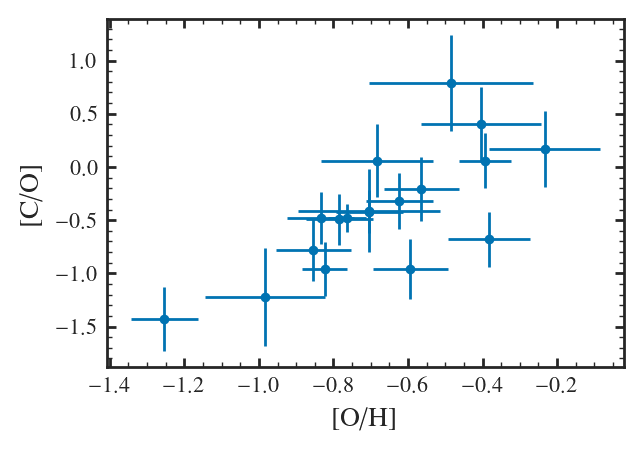

In [149]:
plot_abund_errs(pg17)

verified

## General studies

In [150]:
cel_raw = {}

dirname = "../../data/nearby_CEL/"
for filename in os.listdir(dirname):
    if filename.startswith("_"):
        continue
    if filename.endswith(".toml"):
        print(filename)
        with open(dirname + filename, "r") as f:
            name = os.path.splitext(filename)[0]
            cel_raw[name] = toml.load(f)


garnett+1995.toml
senchyna+17.toml
izotov+thuan1999.toml
garnett+1999.toml


In [151]:
CEL = pd.DataFrame()


for study, attrs in cel_raw.items():
    print(study)
    series = pd.DataFrame(attrs["regions"])
    series["study"] = study
    CEL = pd.concat([CEL, series], ignore_index=True, axis=0)


garnett+1995
senchyna+17
izotov+thuan1999
garnett+1999


In [152]:
CEL.loc[~np.isnan(CEL.log_O_H), "eps_O"] = 12 + CEL.log_O_H
CEL.loc[~np.isnan(CEL.log_O_H), "eps_O_err"] = CEL.log_O_H_err
CEL

,region,galaxy,class,log_O_H,log_O_H_err,T_e,T_e_err,ICF_C_O,ICF_C_O_err,log_C_O,log_C_O_err,study,id,eps_O,eps_O_err
0,30 Dor,LMC,magellanic,-3.70,0.10,10400.0,400.0,1.06,0.14,-0.480,0.260,garnett+1995,NaN,8.30,0.10
1,SMC N88A,SMC,magellanic,-3.91,0.04,14000.0,500.0,1.33,0.48,-0.720,0.170,garnett+1995,NaN,8.09,0.04
2,NGC 2363,NaN,magellanic,-4.08,0.04,14800.0,500.0,1.31,0.45,-0.630,0.150,garnett+1995,NaN,7.92,0.04
3,C1543+091,I Zw 18,dwarf,-4.24,0.10,16100.0,500.0,1.20,0.30,-0.810,0.150,garnett+1995,NaN,7.76,0.10
4,Tol 1214-277,NaN,dwarf,-4.41,0.05,17800.0,800.0,1.32,0.45,-0.800,0.280,garnett+1995,NaN,7.59,0.05
5,SBS 0335-052,NaN,dwarf,-4.64,0.06,19500.0,800.0,1.21,0.31,-0.940,0.170,garnett+1995,NaN,7.36,0.06
6,centre,SDSS J094401.87-003832.1,dwarf,NaN,NaN,NaN,NaN,NaN,NaN,-1.360,0.060,senchyna+17,SB2,7.81,0.07
7,centre,SDSS J102429.25+052450.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.810,0.200,senchyna+17,SB36,7.92,0.04
8,"SDSS J094256.74+092816.2,",UGC 5189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.740,0.450,senchyna+17,SB80,8.24,0.06
9,Mrk 193,Mrk 193,dwarf,NaN,NaN,NaN,NaN,NaN,NaN,-0.520,0.040,senchyna+17,SB82,7.91,0.04


In [153]:
CEL["C_O"] = gcem.log_to_brak(CEL.log_C_O, "c", "o")
CEL["C_O_err"] = CEL.log_C_O_err
CEL["O_H"] = gcem.eps_to_brak(CEL.eps_O, "o")
CEL["O_H_err"] = CEL.eps_O_err

In [154]:
CEL

,region,galaxy,class,log_O_H,log_O_H_err,T_e,T_e_err,ICF_C_O,ICF_C_O_err,log_C_O,log_C_O_err,study,id,eps_O,eps_O_err,C_O,C_O_err,O_H,O_H_err
0,30 Dor,LMC,magellanic,-3.70,0.10,10400.0,400.0,1.06,0.14,-0.480,0.260,garnett+1995,NaN,8.30,0.10,-0.26963,0.260,-0.513789,0.10
1,SMC N88A,SMC,magellanic,-3.91,0.04,14000.0,500.0,1.33,0.48,-0.720,0.170,garnett+1995,NaN,8.09,0.04,-0.50963,0.170,-0.723789,0.04
2,NGC 2363,NaN,magellanic,-4.08,0.04,14800.0,500.0,1.31,0.45,-0.630,0.150,garnett+1995,NaN,7.92,0.04,-0.41963,0.150,-0.893789,0.04
3,C1543+091,I Zw 18,dwarf,-4.24,0.10,16100.0,500.0,1.20,0.30,-0.810,0.150,garnett+1995,NaN,7.76,0.10,-0.59963,0.150,-1.053789,0.10
4,Tol 1214-277,NaN,dwarf,-4.41,0.05,17800.0,800.0,1.32,0.45,-0.800,0.280,garnett+1995,NaN,7.59,0.05,-0.58963,0.280,-1.223789,0.05
5,SBS 0335-052,NaN,dwarf,-4.64,0.06,19500.0,800.0,1.21,0.31,-0.940,0.170,garnett+1995,NaN,7.36,0.06,-0.72963,0.170,-1.453789,0.06
6,centre,SDSS J094401.87-003832.1,dwarf,NaN,NaN,NaN,NaN,NaN,NaN,-1.360,0.060,senchyna+17,SB2,7.81,0.07,-1.14963,0.060,-1.003789,0.07
7,centre,SDSS J102429.25+052450.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.810,0.200,senchyna+17,SB36,7.92,0.04,-0.59963,0.200,-0.893789,0.04
8,"SDSS J094256.74+092816.2,",UGC 5189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.740,0.450,senchyna+17,SB80,8.24,0.06,-0.52963,0.450,-0.573789,0.06
9,Mrk 193,Mrk 193,dwarf,NaN,NaN,NaN,NaN,NaN,NaN,-0.520,0.040,senchyna+17,SB82,7.91,0.04,-0.30963,0.040,-0.903789,0.04


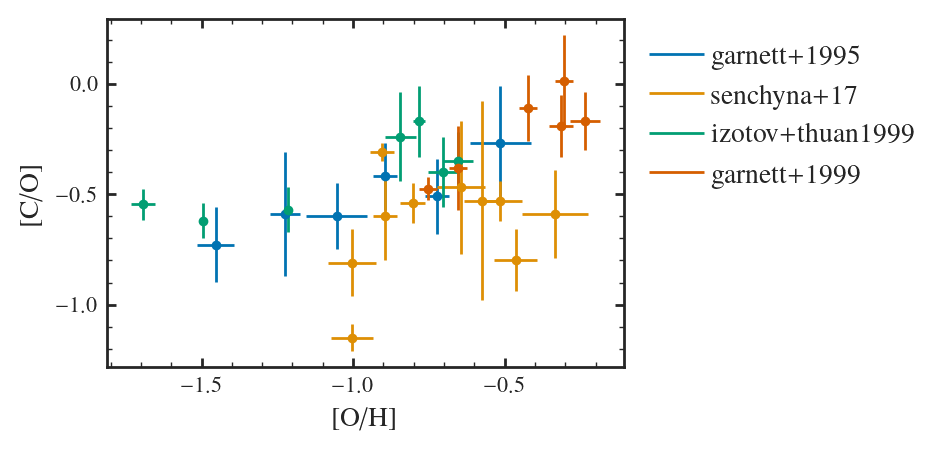

In [155]:
for label in CEL.study.unique():
    df = CEL.loc[CEL.study == label]

    plot_abund_errs(df, label=label)
    
arya.Legend(loc=-1)

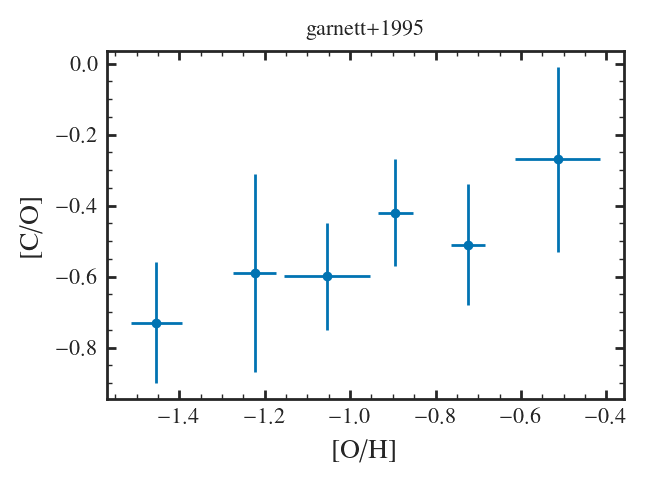

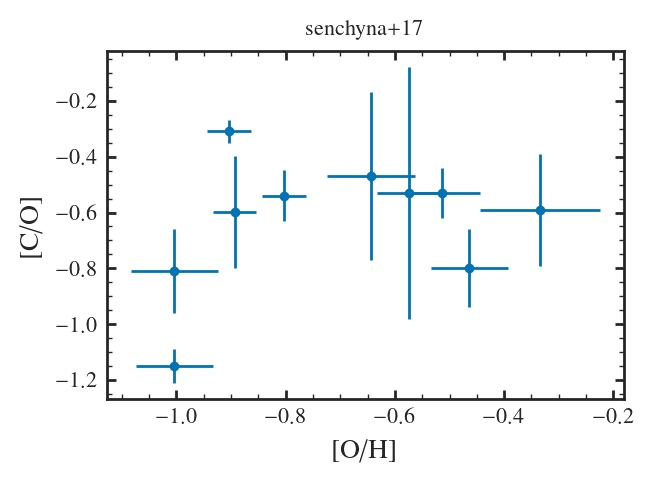

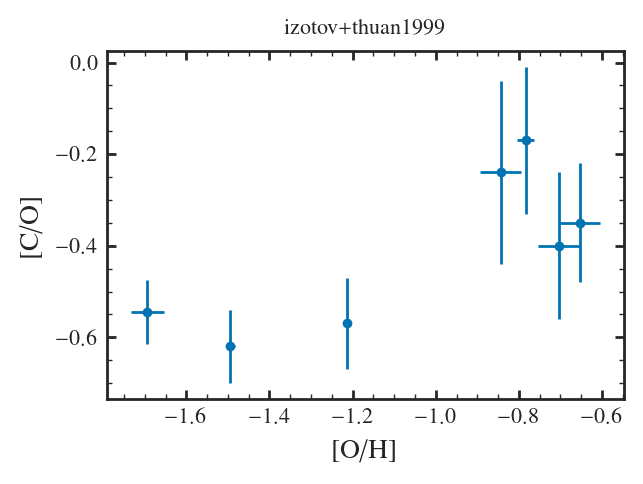

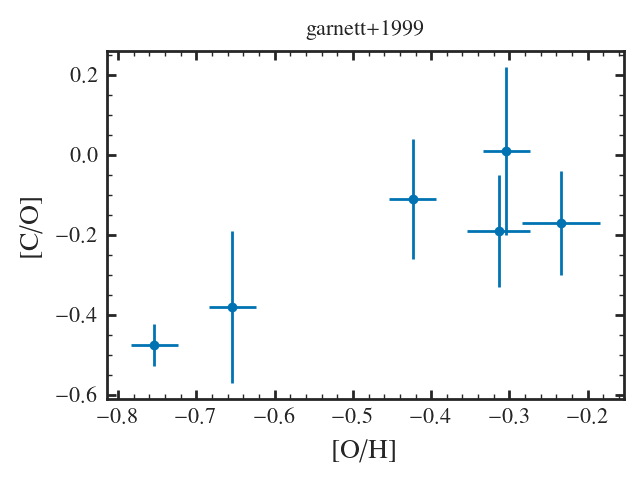

In [156]:
for label in CEL.study.unique():
    df = CEL.loc[CEL.study == label]

    plot_abund_errs(df, label=label)
    plt.title(label)
    plt.show()


Verified
- garnett 1999
- garnett 1995
- izotov+thuan
- no plot for senchyna

## Berg et al. 2019

CEL using UV spectroscopy from HST


In [172]:
berg19_oh = [7.738564437848462, 7.6632886767478245, 7.747268460952228, 7.750820263928443, 7.713715855761903, 7.589795836508764, 7.6974589868035785, 7.645978901768882, 7.6295676065942, 7.544970117524367, 7.612033211664193, 7.583534555372829, 7.72890577995267, 7.697318599334163, 7.712185632345273, 7.868184188359874, 7.91372588343829, 7.910117925474309, 8.026962416268903]
berg19_co = [-0.3746933819064967, -0.48816029143898, -0.5211171827565271, -0.5504310868245295, -0.5995992714025501, -0.6620036429872496, -0.7178384942319369, -0.7848573163327262, -0.8006435944140862, -0.8836429872495446, -0.9455737704918032, -1.038554948391014, -1.0339647844565878, -0.7561748633879781, -0.7804857316332725, -0.655397692774742, -0.5993321190042502, -0.7889981785063751, -0.8897632058287797]

In [173]:
surp.set_yields()

In [174]:
berg19 = pd.read_csv(DATA_DIR + "nearby_CEL/berg+19.tsv", sep="\t+", comment="#")
berg19 = berg19.iloc[:-1]
berg19["C_O"] = gcem.log_to_brak(berg19.log_c_o, "c", "o")
berg19["O_H"] = gcem.eps_to_brak(berg19.eps_o, "o")
berg19["C_O_err"] = berg19.log_c_o_err
berg19["O_H_err"] = berg19.eps_o_err

/tmp/ipykernel_2647991/3436396364.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  berg19 = pd.read_csv(DATA_DIR + "nearby_CEL/berg+19.tsv", sep="\t+", comment="#")


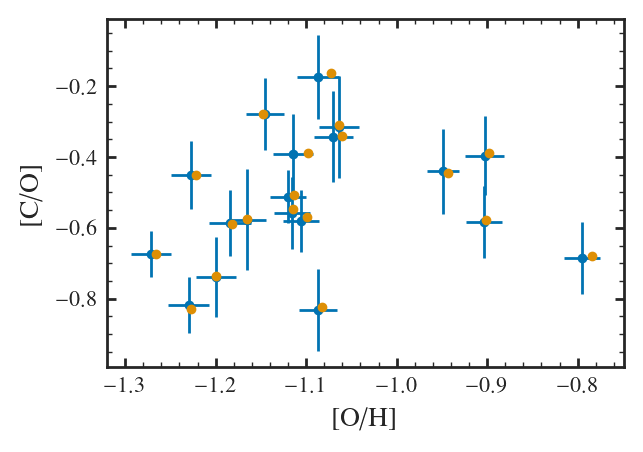

In [175]:
plt.scatter(berg19_oh + eps_o_correction - 0.15, berg19_co + c_o_correction, color=COLORS[1], zorder=3)
plot_abund_errs(berg19)

## Berg 2016

Carbon lines
- C IV 1548.19 (3)
- C IV 1550.77 (3)
- C III] 1906.68 (all - 1)
- C III 1908.73 (all)
about 8 O lines, and 4 H lines. No Fe.

In [176]:
berg16 = pd.read_csv(DATA_DIR + "nearby_CEL/berg+16.tsv", sep="\t+", comment="#")
berg16["C_O"] = gcem.log_to_brak(berg16.log_c_o, "c", "o")
berg16["O_H"] = gcem.eps_to_brak(berg16.eps_o, "o")
berg16["C_O_err"] = berg16.log_c_o_err
berg16["O_H_err"] = berg16.eps_o_err

/tmp/ipykernel_2647991/527315078.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  berg16 = pd.read_csv(DATA_DIR + "nearby_CEL/berg+16.tsv", sep="\t+", comment="#")


In [177]:
berg16_eps_o = [7.45492559464121, 7.45492559464121, 7.446516385223216, 7.738760980305644, 7.812141510569171, 7.844879868436886, 7.91093217279692]
berg16_co = [-0.44879174256223436, -0.5934790528233151, -0.6725804493017608, -0.8203400121432909, -0.6636915604128719, -0.6061323618700668, -0.6431086824529447]

In [178]:
berg16_eps_o = [7.3688668986515875, 7.451109177903437, 7.4524684645498045, 7.732209656372336, 7.901859504132231, 7.808971291866029, 7.841028708133972]
berg16_co = [-0.2890780583536705, -0.45288545792930646, -0.7084163112195758, -0.8311306476258066, -0.7682472897913665, -0.6335624126469162, -0.5935121552042524]

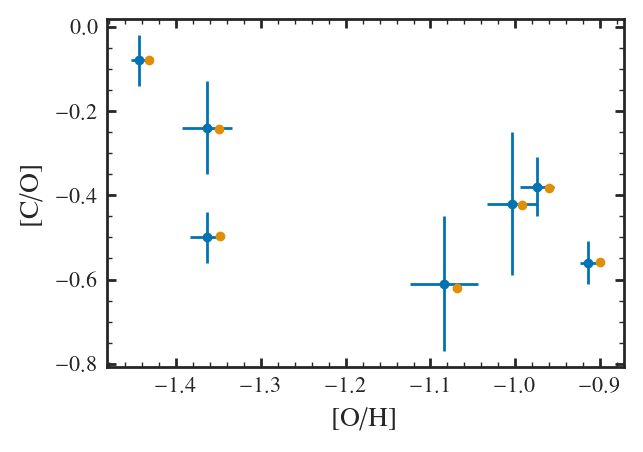

In [179]:
plot_abund_errs(berg16)
plt.scatter(berg16_eps_o + eps_o_correction - 0.14, berg16_co + c_o_correction, color=COLORS[1], zorder=3)


## All

In [180]:
berg16["study"] = "berg+16"
berg19["study"] = "berg+19"


In [181]:
CEL_all = pd.concat([CEL, berg16, berg19, pg17], ignore_index=True)
dwarf_err = calc_errs(CEL)

In [182]:
CEL_all[["region", "galaxy", "study"]].values

array([['30 Dor', 'LMC', 'garnett+1995'],
       ['SMC N88A', 'SMC', 'garnett+1995'],
       ['NGC 2363', nan, 'garnett+1995'],
       ['C1543+091', 'I Zw 18', 'garnett+1995'],
       ['Tol 1214-277', nan, 'garnett+1995'],
       ['SBS 0335-052', nan, 'garnett+1995'],
       ['centre', 'SDSS J094401.87-003832.1', 'senchyna+17'],
       ['centre', 'SDSS J102429.25+052450.9', 'senchyna+17'],
       ['SDSS J094256.74+092816.2,', 'UGC 5189', 'senchyna+17'],
       ['Mrk 193', 'Mrk 193', 'senchyna+17'],
       ['centre', 'SDSS J094252.78+354726.0', 'senchyna+17'],
       ['centre', 'LEDA 41360', 'senchyna+17'],
       ['LEDA 35380', 'IC 700', 'senchyna+17'],
       ['centre', 'LEDA 36857', 'senchyna+17'],
       ['Mrk 1315', 'NGC 4204', 'senchyna+17'],
       ['SDSS J122225.79+043404.7', 'NGC 4301', 'senchyna+17'],
       ['I Zw 18', nan, 'izotov+thuan1999'],
       ['SBS 0335-052', nan, 'izotov+thuan1999'],
       ['SBS 1415+437', nan, 'izotov+thuan1999'],
       ['UM 469', nan, 'izotov+th

In [183]:
CEL_all.study.unique()

array(['garnett+1995', 'senchyna+17', 'izotov+thuan1999', 'garnett+1999',
       'berg+16', 'berg+19', 'pena-guerreno+17'], dtype=object)

In [186]:
filt = pd.isna(CEL_all.galaxy)
CEL_all.loc[filt, "galaxy"] = CEL_all.loc[filt, "region"]
# filt = pd.isna(CEL_all.galaxy)
# CEL_all.loc[filt, "galaxy"] = CEL_all.loc[filt, "name"]


In [187]:
CEL_all[["region", "galaxy", "study"]].values

array([['30 Dor', 'LMC', 'garnett+1995'],
       ['SMC N88A', 'SMC', 'garnett+1995'],
       ['NGC 2363', 'NGC 2363', 'garnett+1995'],
       ['C1543+091', 'I Zw 18', 'garnett+1995'],
       ['Tol 1214-277', 'Tol 1214-277', 'garnett+1995'],
       ['SBS 0335-052', 'SBS 0335-052', 'garnett+1995'],
       ['centre', 'SDSS J094401.87-003832.1', 'senchyna+17'],
       ['centre', 'SDSS J102429.25+052450.9', 'senchyna+17'],
       ['SDSS J094256.74+092816.2,', 'UGC 5189', 'senchyna+17'],
       ['Mrk 193', 'Mrk 193', 'senchyna+17'],
       ['centre', 'SDSS J094252.78+354726.0', 'senchyna+17'],
       ['centre', 'LEDA 41360', 'senchyna+17'],
       ['LEDA 35380', 'IC 700', 'senchyna+17'],
       ['centre', 'LEDA 36857', 'senchyna+17'],
       ['Mrk 1315', 'NGC 4204', 'senchyna+17'],
       ['SDSS J122225.79+043404.7', 'NGC 4301', 'senchyna+17'],
       ['I Zw 18', 'I Zw 18', 'izotov+thuan1999'],
       ['SBS 0335-052', 'SBS 0335-052', 'izotov+thuan1999'],
       ['SBS 1415+437', 'SBS 1415+437

In [188]:
CEL_all.loc[CEL_all.galaxy.duplicated(keep=False), ["region", "galaxy", "study", "class", "C_O", "O_H"]]

,region,galaxy,study,class,C_O,O_H
3,C1543+091,I Zw 18,garnett+1995,dwarf,-0.59963,-1.053789
5,SBS 0335-052,SBS 0335-052,garnett+1995,dwarf,-0.72963,-1.453789
16,I Zw 18,I Zw 18,izotov+thuan1999,dwarf,-0.54463,-1.693789
17,SBS 0335-052,SBS 0335-052,izotov+thuan1999,dwarf,-0.61963,-1.493789
18,SBS 1415+437,SBS 1415+437,izotov+thuan1999,dwarf,-0.56963,-1.213789
23,NGC 5455,M101,garnett+1999,NaN,-0.10963,-0.423789
24,NGC 5461,M101,garnett+1999,NaN,0.01037,-0.303789
25,NGC 5471,M101,garnett+1999,NaN,-0.47463,-0.753789
26,VS 38,NGC 2403,garnett+1999,NaN,-0.16963,-0.233789
27,VS 44,NGC 2403,garnett+1999,NaN,-0.18963,-0.313789


the only true duplicates are two regions in garnett+1995 covered by izotov+thuan 1999

In [189]:
CEL_cleaned = CEL_all.drop([3, 5, 18])

WARNING:
make sure the above is correct since easier to manualy drop rows

In [190]:
CEL_cleaned[CEL_cleaned.galaxy.duplicated(keep=False)].study

23    garnett+1999
24    garnett+1999
25    garnett+1999
26    garnett+1999
27    garnett+1999
28    garnett+1999
Name: study, dtype: object

In [191]:
np.sum(np.isnan(CEL_cleaned.C_O_err))

np.int64(0)

In [192]:
CEL_cleaned

,region,galaxy,class,log_O_H,log_O_H_err,T_e,T_e_err,ICF_C_O,ICF_C_O_err,log_C_O,...,O_H,O_H_err,eps_o,eps_o_err,log_c_o,log_c_o_err,eps_c,eps_c_err,C_H,C_H_err
0,30 Dor,LMC,magellanic,-3.70,0.10,10400.0,400.0,1.06,0.14,-0.48,...,-0.513789,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SMC N88A,SMC,magellanic,-3.91,0.04,14000.0,500.0,1.33,0.48,-0.72,...,-0.723789,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NGC 2363,NGC 2363,magellanic,-4.08,0.04,14800.0,500.0,1.31,0.45,-0.63,...,-0.893789,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tol 1214-277,Tol 1214-277,dwarf,-4.41,0.05,17800.0,800.0,1.32,0.45,-0.80,...,-1.223789,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,centre,SDSS J094401.87-003832.1,dwarf,NaN,NaN,NaN,NaN,NaN,NaN,-1.36,...,-1.003789,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,POX 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.763789,0.05,8.05,0.05,NaN,NaN,7.36,0.08,-1.243419,0.08
69,NaN,SBS 1319+579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.623789,0.09,8.19,0.09,NaN,NaN,7.66,0.17,-0.943419,0.17
70,NaN,SBS 1415+437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.253789,0.09,7.56,0.09,NaN,NaN,5.92,0.21,-2.683419,0.21
71,NaN,Tol 1457-262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.983789,0.16,7.83,0.16,NaN,NaN,6.40,0.30,-2.203419,0.30


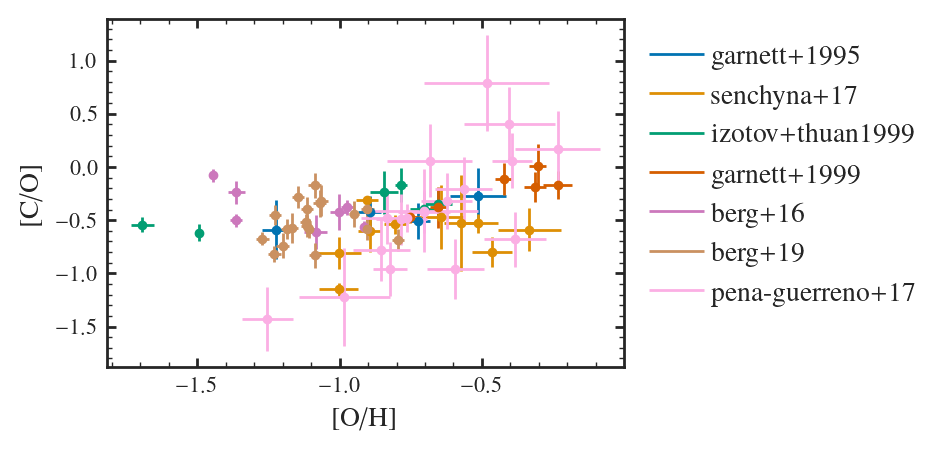

In [193]:
for study in CEL_cleaned.study.unique():
    df = CEL_cleaned[CEL_cleaned.study == study]
    plot_abund_errs(df, label=study)

arya.Legend(-1)

In [194]:
CEL_cleaned.to_csv("CEL_combined.csv")

In [195]:
lt = dataframe_to_latex_with_errors(CEL_cleaned[["galaxy", "region", "C_O_err", "C_O", "O_H_err", "O_H", "study"]], precisions={})

print(lt)

\begin{table}[H]
\centering
\begin{tabular}{lllll}
\toprule
galaxy & region & C_O & O_H & study \\
\midrule
LMC & 30 Dor & $-0.27 \pm 0.26$ & $-0.51 \pm 0.10$ & garnett+1995 \\
SMC & SMC N88A & $-0.51 \pm 0.17$ & $-0.72 \pm 0.04$ & garnett+1995 \\
NGC 2363 & NGC 2363 & $-0.42 \pm 0.15$ & $-0.89 \pm 0.04$ & garnett+1995 \\
Tol 1214-277 & Tol 1214-277 & $-0.59 \pm 0.28$ & $-1.22 \pm 0.05$ & garnett+1995 \\
SDSS J094401.87-003832.1 & centre & $-1.15 \pm 0.06$ & $-1.00 \pm 0.07$ & senchyna+17 \\
SDSS J102429.25+052450.9 & centre & $-0.60 \pm 0.20$ & $-0.89 \pm 0.04$ & senchyna+17 \\
UGC 5189 & SDSS J094256.74+092816.2, & $-0.53 \pm 0.45$ & $-0.57 \pm 0.06$ & senchyna+17 \\
Mrk 193 & Mrk 193 & $-0.31 \pm 0.04$ & $-0.90 \pm 0.04$ & senchyna+17 \\
SDSS J094252.78+354726.0 & centre & $-0.47 \pm 0.30$ & $-0.64 \pm 0.08$ & senchyna+17 \\
LEDA 41360 & centre & $-0.81 \pm 0.15$ & $-1.00 \pm 0.08$ & senchyna+17 \\
IC 700 & LEDA 35380 & $-0.80 \pm 0.14$ & $-0.46 \pm 0.07$ & senchyna+17 \\
LEDA 36857

# Comparing RL and CEL

In [196]:
?plot_abund_errs

Signature: plot_abund_errs(df, x='O_H', y='C_O', fmt='o', **kwargs)
Docstring: <no docstring>
File:      /tmp/ipykernel_2647991/493877850.py
Type:      function

NGC 5461 M101
2
NGC 5455 M101
2
NGC 5471 M101
2
30 Dor LMC
2
VS 38 NGC 2403
2
VS 44 NGC 2403
2


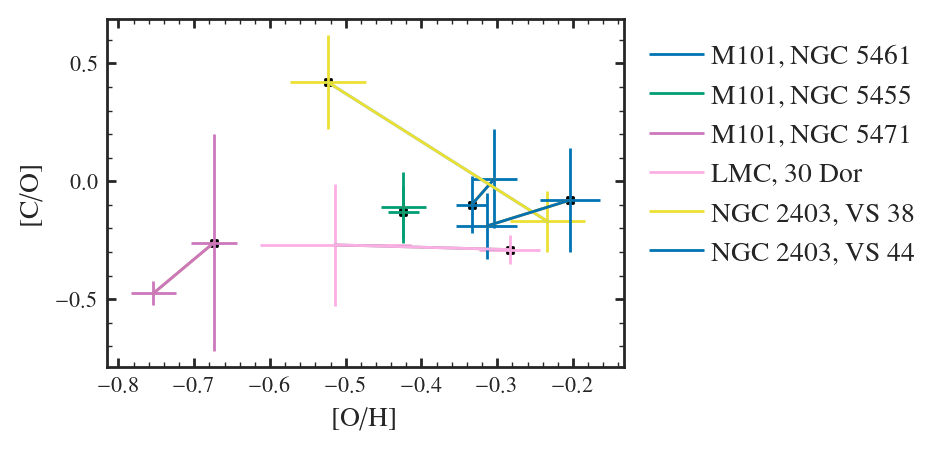

In [197]:
for i, row in RL_clean.drop_duplicates(["galaxy", "region"]).iterrows():

    filt_d = CEL_cleaned.galaxy == row.galaxy
    filt_d &= CEL_cleaned.region == row.region

    if np.sum(filt_d) > 0:    
        print(CEL_cleaned[filt_d].region.iloc[0], CEL_cleaned[filt_d].galaxy.iloc[0])

        df = pd.DataFrame([CEL_cleaned[filt_d].iloc[0], row])
        print(len(df))
        plot_abund_errs(df, fmt="-", label=f"{row.galaxy}, {row.region}")
        plt.plot(df.O_H, df.C_O)
        plt.scatter(row.O_H, row.C_O, marker="s", color="black")

arya.Legend(-1)

In [198]:
CEL_cleaned

,region,galaxy,class,log_O_H,log_O_H_err,T_e,T_e_err,ICF_C_O,ICF_C_O_err,log_C_O,...,O_H,O_H_err,eps_o,eps_o_err,log_c_o,log_c_o_err,eps_c,eps_c_err,C_H,C_H_err
0,30 Dor,LMC,magellanic,-3.70,0.10,10400.0,400.0,1.06,0.14,-0.48,...,-0.513789,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SMC N88A,SMC,magellanic,-3.91,0.04,14000.0,500.0,1.33,0.48,-0.72,...,-0.723789,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NGC 2363,NGC 2363,magellanic,-4.08,0.04,14800.0,500.0,1.31,0.45,-0.63,...,-0.893789,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tol 1214-277,Tol 1214-277,dwarf,-4.41,0.05,17800.0,800.0,1.32,0.45,-0.80,...,-1.223789,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,centre,SDSS J094401.87-003832.1,dwarf,NaN,NaN,NaN,NaN,NaN,NaN,-1.36,...,-1.003789,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,POX 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.763789,0.05,8.05,0.05,NaN,NaN,7.36,0.08,-1.243419,0.08
69,NaN,SBS 1319+579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.623789,0.09,8.19,0.09,NaN,NaN,7.66,0.17,-0.943419,0.17
70,NaN,SBS 1415+437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.253789,0.09,7.56,0.09,NaN,NaN,5.92,0.21,-2.683419,0.21
71,NaN,Tol 1457-262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.983789,0.16,7.83,0.16,NaN,NaN,6.40,0.30,-2.203419,0.30


In [199]:
RL_clean

,galaxy,class,region,eps_C,eps_C_err,eps_N,eps_N_err,eps_O,eps_O_err,eps_Fe,...,log_c_o_cel_err,C_O_2,C_O_2_err,c_err,eps_n,n_err,o_err,eps_fe,fe_err,C_H_err
5,NGC 6822,dwarf,region V,8.01,0.12,6.85,0.15,8.37,0.09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MW,MW,Sh 2-311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MW,MW,NGC 2579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MW,MW,NGC 3576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MW,MW,NGC 3603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MW,MW,M8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MW,MW,M16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MW,MW,M17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MW,MW,M20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MW,MW,M42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


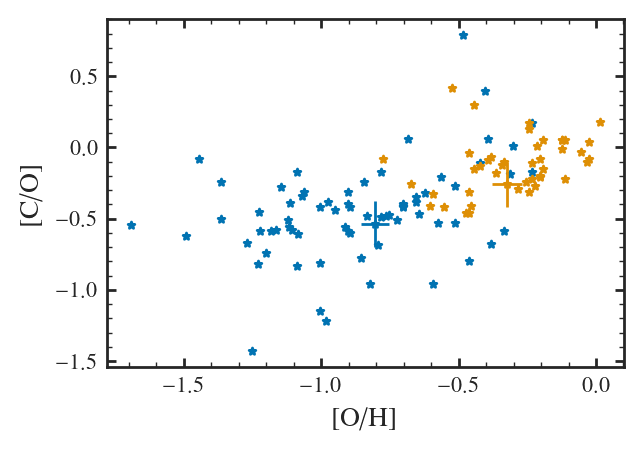

In [200]:
plot_sample_err(CEL_cleaned, dwarf_err)
plot_sample_err(RL_clean, RL_err, color=arya.COLORS[1])

# DLA
- Mostly as compiled in Cook et al. 2017.

In [201]:
import os

In [202]:
dla_raw = {}

dirname = "../../data/DLA/"
for filename in os.listdir(dirname):
    if filename.startswith("_"):
        continue
    if filename.endswith(".toml"):
        print(filename)
        with open(dirname + filename, "r") as f:
            name = os.path.splitext(filename)[0]
            dla_raw[name] = toml.load(f)


omera+01.toml
cooke+14.toml
welsh+2022.toml
ellison+10.toml
welsh+20.toml
cooke+18.toml
riemer-sorensen+17.toml
dessauges-zavadsky+03.toml
cooke+17.toml
cooke+11.toml
dutta+14.toml
morrison+16.toml
srianand+10.toml
pettini+08.toml
kislitsyn+24.toml
cooke+15.toml


In [203]:
cols = ["galaxy", "redshift", "log_HI", "log_HI_err", "log_CII", "log_CII_err", "log_OI", "log_OI_err"]

dla = pd.DataFrame()


for study, attrs in dla_raw.items():
    print(study)
    series = pd.DataFrame(attrs["galaxies"])
    series["study"] = study
    dla = pd.concat([dla, series], ignore_index=True, axis=0)


omera+01
cooke+14
welsh+2022
ellison+10
welsh+20
cooke+18
riemer-sorensen+17
dessauges-zavadsky+03
cooke+17
cooke+11
dutta+14
morrison+16
srianand+10
pettini+08
kislitsyn+24
cooke+15


In [204]:
dla.columns

Index(['galaxy', 'redshift', 'redshift_err', 'log_HI', 'log_HI_err', 'log_NI',
       'log_NI_err', 'log_OI', 'log_OI_err', 'log_CII', 'log_CII_err',
       'log_SiII', 'log_SiII_err', 'log_AlII', 'log_AlII_err', 'log_FeII',
       'log_FeII_err', 'log_CIII', 'log_CIII_err', 'log_CIV', 'log_CIV_err',
       'log_NII', 'log_NII_err', 'log_SiIII', 'log_SiIII_err', 'log_SiIV',
       'log_SiIV_err', 'study', 'log_SII', 'log_SII_err', 'solar_scale',
       'notes', 'HI_lines', 'CII_lines', 'OI_lines', 'SiII_lines',
       'FeII_lines', 'c_o', 'c_o_err', 'o_h', 'o_h_err', 'log_c', 'log_c_err',
       'log_MgII', 'log_MgII_err', 'log_FeIII', 'log_FeIII_err', 'c_h',
       'c_h_err', 'C_IC1', 'C_IC2', 'O_IC1', 'O_IC2', 'Si_IC1', 'Si_IC2',
       'Fe_IC1', 'Fe_IC2', 'log_c_o', 'log_c_o_err'],
      dtype='object')

In [205]:
dla["C_O"] = gcem.log_to_brak(dla.log_CII - dla.log_OI, "c", "o")
dla["C_O_err"] = np.sqrt(dla.log_OI_err**2 + dla.log_CII_err**2)

dla["O_H"] = gcem.eps_to_brak(12 + dla.log_OI - dla.log_HI, "o")
dla["O_H_err"] = np.sqrt(dla.log_OI_err**2 + dla.log_HI_err**2)

flagged 
- HS 0105 (C/O); okay?
- Q0913+072	 (C/O + err; good)
- Q1202+3235	(C/o; IC only)

In [206]:
c_o_correction

np.float64(0.21059882009471712)

In [207]:
cooke17_rep= dla[np.isin(dla.study, ["omera+01", "ellison+10", "cooke+11", "cooke+14", "cooke+15", "cooke+17", "dutta+14",
                                     "dessauges-zavadsky+03", "pettini+08", "srianand+10", "morrison+16"])]
idx = np.argsort((np.int64(cooke17_rep.galaxy.str.extract("(\\d+)")))[:, 0])
idx = idx[~np.isin(cooke17_rep.galaxy.iloc[idx], ["Q2059-360", "Q1101-264"])]
idx = idx[1:] # remove duplicate first galaxy
cooke17_rep = cooke17_rep.iloc[idx][["galaxy", "redshift", "C_O", "C_O_err", "O_H", "O_H_err", "study", "log_CII"]]

cooke17_rep

,galaxy,redshift,C_O,C_O_err,O_H,O_H_err,study,log_CII
22,J0035-0918,2.340000,0.03037,0.161555,-2.563789,0.072111,cooke+15,14.500
0,HS 0105+1619,2.535998,0.18137,0.073055,-1.857789,0.025632,omera+01,14.349
3,J0140-0839,3.696000,-0.34963,0.080623,-2.873789,0.150333,ellison+10,14.130
11,J0311-1722,3.734000,-0.46963,0.113137,-2.413789,0.100000,cooke+11,14.020
10,J0903+2628,3.077590,-0.42963,0.036056,-3.173789,0.053852,cooke+17,13.320
17,Q0913+072,2.618000,-0.43963,0.050990,-2.523789,0.041231,pettini+08,13.980
14,J0953-0504,4.202870,-0.54963,0.028284,-2.673789,0.101980,dutta+14,13.930
12,J1001+0343,3.078000,-0.45963,0.028284,-2.773789,0.053852,cooke+11,13.580
18,J1016+4040,2.816000,-0.25963,0.050000,-2.583789,0.114018,pettini+08,13.660
23,J1111+1332,2.270000,-0.22963,0.114018,-2.043789,0.080623,cooke+15,14.720


In [208]:

dla.galaxy[dla.galaxy.duplicated()]

13    J0035-0918
22    J0035-0918
Name: galaxy, dtype: object

In [209]:
# remove duplicates

filt = ~((dla.galaxy == "J0035-0918") & (dla.study != "welsh+20"))
dla = dla[filt]

In [210]:
np.sum(dla.galaxy.duplicated())

np.int64(0)

In [211]:
np.sort(dla.galaxy)

array(['HS 0105+1619', 'J0035-0918', 'J0140-0839', 'J0311-1722',
       'J0903+2628', 'J0953-0504', 'J0955+4116', 'J1001+0343',
       'J1016+4040', 'J1111+1332', 'J1332+0052', 'J1337+3152',
       'J1358+6522', 'J1558+4053', 'J2155+1358', 'PKS1937-101',
       'Q0913+072', 'Q1101-264', 'Q1202+3235', 'Q1243+307', 'Q2059-360',
       'Q2206-199'], dtype=object)

In [212]:
dla[["galaxy", "study", "C_O", "O_H"]]

,galaxy,study,C_O,O_H
0,HS 0105+1619,omera+01,0.18137,-1.857789
1,J1358+6522,cooke+14,-0.31963,-2.443789
2,J0955+4116,welsh+2022,-0.50963,-2.573789
3,J0140-0839,ellison+10,-0.34963,-2.873789
4,J0035-0918,welsh+20,-0.16963,-2.573789
5,Q1243+307,cooke+18,0.19237,-2.893789
6,PKS1937-101,riemer-sorensen+17,1.50737,-2.678789
7,Q1101-264,dessauges-zavadsky+03,0.72037,-1.763789
8,Q2059-360,dessauges-zavadsky+03,-0.45963,-1.483789
9,J2155+1358,dessauges-zavadsky+03,-0.33963,-1.923789


The table is verified. The main difference is cooke does apply the ionization correction to morrison+16; and cooke does not include the first two galaxies in 

In [213]:
lt = dataframe_to_latex_with_errors(dla[["galaxy", "redshift", "C_O_err", "C_O", "O_H_err", "O_H", "study"]], precisions={})

print(lt)

\begin{table}[H]
\centering
\begin{tabular}{lrlll}
\toprule
galaxy & redshift & C_O & O_H & study \\
\midrule
HS 0105+1619 & 2.535998 & $0.18 \pm 0.07$ & $-1.86 \pm 0.03$ & omera+01 \\
J1358+6522 & 3.067259 & $-0.32 \pm 0.06$ & $-2.44 \pm 0.06$ & cooke+14 \\
J0955+4116 & 3.279908 & $-0.51 \pm 0.15$ & $-2.57 \pm 0.06$ & welsh+2022 \\
J0140-0839 & 3.696000 & $-0.35 \pm 0.08$ & $-2.87 \pm 0.15$ & ellison+10 \\
J0035-0918 & 2.340064 & $-0.17 \pm 0.14$ & $-2.57 \pm 0.06$ & welsh+20 \\
Q1243+307 & 2.525640 & $0.19 \pm 0.03$ & $-2.89 \pm 0.03$ & cooke+18 \\
PKS1937-101 & 3.572400 & $1.51 \pm 0.13$ & $-2.68 \pm 0.13$ & riemer-sorensen+17 \\
Q1101-264 & 1.838000 & $0.72 \pm 0.09$ & $-1.76 \pm 0.07$ & dessauges-zavadsky+03 \\
Q2059-360 & 2.507000 & $-0.46 \pm 0.28$ & $-1.48 \pm 0.23$ & dessauges-zavadsky+03 \\
J2155+1358 & 4.212000 & $-0.34 \pm 0.08$ & $-1.92 \pm 0.11$ & dessauges-zavadsky+03 \\
J0903+2628 & 3.077590 & $-0.43 \pm 0.04$ & $-3.17 \pm 0.05$ & cooke+17 \\
J0311-1722 & 3.734000 & $-0

In [214]:
dla[["galaxy", "redshift", "C_O", "C_O_err", "O_H", "O_H_err", "study"]]

,galaxy,redshift,C_O,C_O_err,O_H,O_H_err,study
0,HS 0105+1619,2.535998,0.18137,0.073055,-1.857789,0.025632,omera+01
1,J1358+6522,3.067259,-0.31963,0.063246,-2.443789,0.063246,cooke+14
2,J0955+4116,3.279908,-0.50963,0.145602,-2.573789,0.064031,welsh+2022
3,J0140-0839,3.696000,-0.34963,0.080623,-2.873789,0.150333,ellison+10
4,J0035-0918,2.340064,-0.16963,0.139284,-2.573789,0.064031,welsh+20
5,Q1243+307,2.525640,0.19237,0.026401,-2.893789,0.028231,cooke+18
6,PKS1937-101,3.572400,1.50737,0.130269,-2.678789,0.127142,riemer-sorensen+17
7,Q1101-264,1.838000,0.72037,0.086023,-1.763789,0.070711,dessauges-zavadsky+03
8,Q2059-360,2.507000,-0.45963,0.283196,-1.483789,0.232594,dessauges-zavadsky+03
9,J2155+1358,4.212000,-0.33963,0.078102,-1.923789,0.111803,dessauges-zavadsky+03


In [215]:
ra = cooke17_rep.galaxy.str.extract("(\\d+)")

In [216]:
ra

,0
22,0035
0,0105
3,0140
11,0311
10,0903
17,0913
14,0953
12,1001
18,1016
23,1111


In [217]:
idx

array([17,  0,  2,  7,  6, 13, 10,  8, 14, 18, 11, 12,  1, 15,  5, 16])

Verified!!!

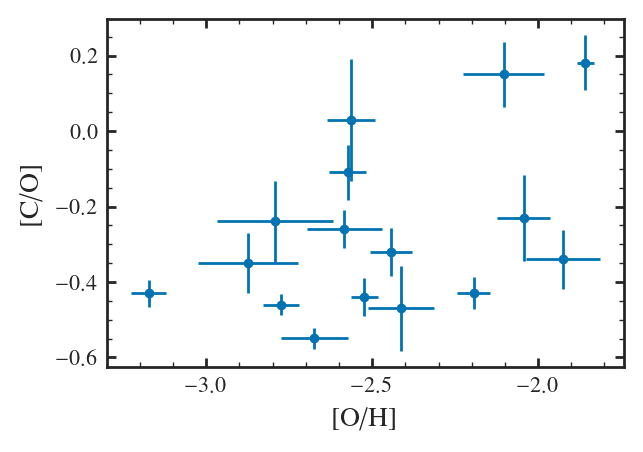

In [218]:
plot_abund_errs(cooke17_rep)

1: Cooke et al. (2015); 2: Dutta et al. (2014); 3: Cooke et al. (2014); 4: Ellison et al. (2010); 5: Cooke et al. (2011b); 6: This work; 7: Pettini et al. (2008); 8: Morrison et al. (2016); 9: Srianand et al. (2010); 10: Cooke et al. (2012); 11: Dessauges-Zavadsky et al. (2003).

In [219]:
dla.to_csv("DLA_combined.csv")

In [220]:
dla.study.unique()

array(['omera+01', 'cooke+14', 'welsh+2022', 'ellison+10', 'welsh+20',
       'cooke+18', 'riemer-sorensen+17', 'dessauges-zavadsky+03',
       'cooke+17', 'cooke+11', 'dutta+14', 'morrison+16', 'srianand+10',
       'pettini+08', 'kislitsyn+24', 'cooke+15'], dtype=object)

# High Z galaxies
High z CEL mentioned in berg and jones

In [221]:
high_z_raw = {}

dirname = "../../data/high_redshift/"
for filename in os.listdir(dirname):
    if filename.startswith("_"):
        continue
    if filename.endswith(".toml"):
        print(filename)
        with open(dirname + filename, "r") as f:
            name = os.path.splitext(filename)[0]
            high_z_raw[name] = toml.load(f)


steidel+2016.toml
stark+2014.toml
mathee+2021.toml
mainali+2020.toml
jones+2023.toml
amorin+2017.toml
iani+2023.toml
james+2014.toml
erb+2010.toml
bayliss+2014.toml
berg+2018.toml
christensen+2014.toml
AC2022.toml


In [222]:

high_z = pd.DataFrame()


for study, attrs in high_z_raw.items():
    print(study)
    series = pd.DataFrame(attrs["galaxies"])
    series["study"] = study
    high_z = pd.concat([high_z, series], ignore_index=True, axis=0)


steidel+2016
stark+2014
mathee+2021
mainali+2020
jones+2023
amorin+2017
iani+2023
james+2014
erb+2010
bayliss+2014
berg+2018
christensen+2014
AC2022


#### Amorin+2017
Verified

In [223]:
amorin2017 = high_z[high_z.study == "amorin+2017"]

Text(0, 0.5, '12 + log (O/H)')

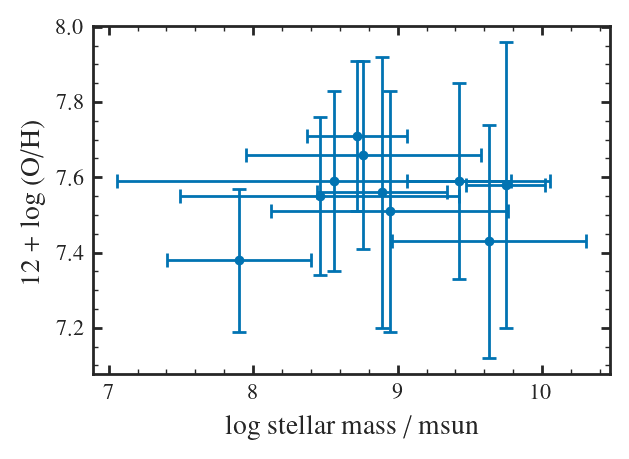

In [224]:
plt.errorbar(np.log10(amorin2017.stellar_mass), amorin2017.eps_o, yerr=amorin2017.eps_o_err, fmt="o", xerr=amorin2017.stellar_mass_err / amorin2017.stellar_mass)
plt.xlabel("log stellar mass / msun")
plt.ylabel("12 + log (O/H)")

Text(0.5, 0, '12 + log (O/H)')

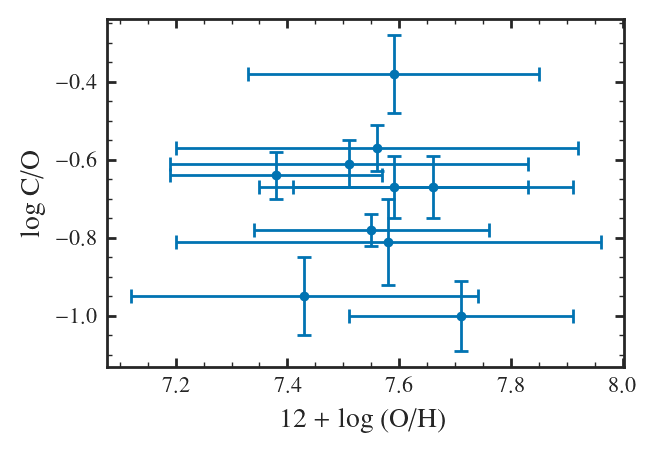

In [225]:
plt.errorbar(amorin2017.eps_o, amorin2017.log_c_o, xerr=amorin2017.eps_o_err, fmt="o", yerr=amorin2017.log_c_o_err)
plt.ylabel("log C/O")
plt.xlabel("12 + log (O/H)")

### Summary

In [226]:
high_z["O_H"] = gcem.eps_to_brak(high_z.eps_o, "o")
high_z["C_O"] = gcem.log_to_brak(high_z.log_c_o, "c", "o")
high_z["O_H_err"] = high_z.eps_o_err
high_z["C_O_err"] = high_z.log_c_o_err

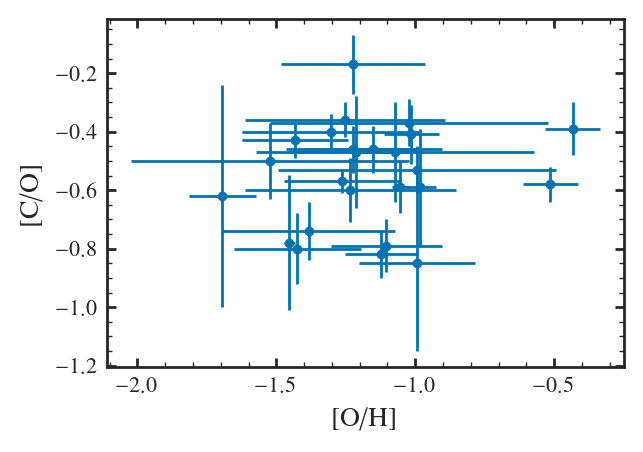

In [227]:
plot_abund_errs(high_z)


In [228]:
high_z.to_csv("high_z_cleaned.csv")

In [229]:
lt = dataframe_to_latex_with_errors(high_z[["galaxy", "redshift", "C_O_err", "C_O", "O_H_err", "O_H", "study"]], precisions={})

print(lt)

\begin{table}[H]
\centering
\begin{tabular}{lrlll}
\toprule
galaxy & redshift & C_O & O_H & study \\
\midrule
MOSFIRE stack & 2.400000 & $-0.39 \pm 0.09$ & $-0.43 \pm 0.10$ & steidel+2016 \\
876_330 & NaN & $-0.47 \pm 0.17$ & $-1.07 \pm 0.50$ & stark+2014 \\
863_348 & NaN & $-0.53 \pm 0.08$ & $-0.99 \pm 0.50$ & stark+2014 \\
860_359 & NaN & $-0.37 \pm 0.08$ & $-1.02 \pm 0.50$ & stark+2014 \\
MARCS 0451-1.1 & NaN & $-0.50 \pm 0.13$ & $-1.52 \pm 0.50$ & stark+2014 \\
XLS-z2 stack & 2.000000 & $-0.59 \pm 0.20$ & $-0.98 \pm 0.06$ & mathee+2021 \\
RXCJ0232−588 & 1.644800 & $-0.47 \pm 0.19$ & $-1.21 \pm 0.24$ & mainali+2020 \\
GLASS 150008 & 6.228950 & $-0.80 \pm 0.12$ & $-1.42 \pm 0.23$ & jones+2023 \\
VUDS 510583858 & 2.414100 & $-0.74 \pm 0.10$ & $-1.38 \pm 0.31$ & amorin+2017 \\
VUDS 510838687 & 2.553900 & $-0.36 \pm 0.06$ & $-1.25 \pm 0.36$ & amorin+2017 \\
VUDS 511267982 & 2.825600 & $-0.46 \pm 0.08$ & $-1.22 \pm 0.24$ & amorin+2017 \\
VUDS5100534435 & 2.963500 & $-0.79 \pm 0.09$ & $-1

# MISC

## FLF

full spectrum fitting to early type galaxies

In [230]:
flf = pd.read_csv(DATA_DIR + "FLF21.csv", comment="#", sep=r"\s+")

FileNotFoundError: [Errno 2] No such file or directory: '/arc7/home/dboyea/surp/surp/../data/FLF21.csv'

In [128]:
flf["O_H"] = flf["[O/Fe]"] + flf["[Fe/H]"]
flf["O_H_err"] = flf["[O/Fe]_err"] + flf["[Fe/H]_err"]
flf["C_O"] = flf["[C/Fe]"] - flf["[O/Fe]"]
flf["C_O_err"] = flf["[C/Fe]_err"] + flf["[O/Fe]_err"]


NameError: name 'flf' is not defined

In [129]:
flf.name.unique()


NameError: name 'flf' is not defined

In [130]:
for name in flf.name.unique():
    df = flf.loc[flf.name == name]
    plot_abund_errs(df, label=name)

arya.Legend(-1)

NameError: name 'flf' is not defined